CatBoost Modelling

In [1]:
import pandas as pd
import numpy as np
import warnings
import os
from sklearn.model_selection import train_test_split

warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', 500)

In [2]:
from expected_score_model.preprocessing.preprocessor import ExpectedScorePreprocessor
from expected_score_model.preprocessing.response import create_expected_score_response

In [3]:
from expected_score_model.modelling.supermodel.supercatboost import SuperCatBoostClassifier

In [4]:
from expected_score_model.evaluation.model_evaluator import ModelEvaluator
from expected_score_model.evaluation.classification_evaluator import ClassificationModelEvaluator
from expected_score_model.evaluation.regression_evaluator import RegressionModelEvaluator
from expected_score_model.evaluation.catboost_evaluator import CatBoostEvaluator

In [5]:
from AFLPy.AFLData_Client import load_data, upload_data

Data

In [6]:
chains = load_data(Dataset_Name="AFL_API_Match_Chains", ID = "AFL")

In [7]:
chains = create_expected_score_response(chains).reset_index(drop=True)

In [8]:
chains.head()

CD_Player_ID  Chain_Number Team_Chain Initial_State Final_State  \
0          NaN             1   Brisbane  centreBounce    turnover   
1   CD_I293535             1   Brisbane  centreBounce    turnover   
2   CD_I293535             1   Brisbane  centreBounce    turnover   
3  CD_I1002401             1   Brisbane  centreBounce    turnover   
4  CD_I1002401             1   Brisbane  centreBounce    turnover   

   Period_Number  Period_Duration_Chain_Start        Description   Disposal  \
0            1.0                          0.0      Centre Bounce        NaN   
1            1.0                          0.0      Hard Ball Get        NaN   
2            1.0                          0.0           Handball  effective   
3            1.0                          0.0  Handball Received        NaN   
4            1.0                          0.0           Handball  effective   

  Shot_At_Goal Behind_Detail  Order  Period_Duration     x     y Home_Team  \
0          NaN           NaN    1.0              0.0   0.0   0.0    Sydney   
1          NaN           NaN    2.0              8.0 -12.0 -11.0    Sydney   
2          NaN           NaN    3.0              8.0 -13.0 -11.0    Sydney   
3          NaN           NaN    4.0             10.0 -19.0 -13.0    Sydney   
4          NaN           NaN    5.0             10.0 -19.0 -11.0    Sydney   

  Away_Team Home_Team_Direction_Q1  Venue_Width  Venue_Length  \
0  Brisbane                  right        141.0         160.0   
1  Brisbane                  right        141.0         160.0   
2  Brisbane                  right        141.0         160.0   
3  Brisbane                  right        141.0         160.0   
4  Brisbane                  right        141.0         160.0   

               Player      Team                     Match_ID  \
0                 NaN       NaN  AFL_2024_F4_Sydney_Brisbane   
1        Lachie Neale  Brisbane  AFL_2024_F4_Sydney_Brisbane   
2        Lachie Neale  Brisbane  AFL_2024_F4_Sydney_Brisbane   
3  Brandon Starcevich  Brisbane  AFL_2024_F4_Sydney_Brisbane   
4  Brandon Starcevich  Brisbane  AFL_2024_F4_Sydney_Brisbane   

            Player_ID result  score  miss  behind  goal  
0                 NaN   miss      0     1       0     0  
1        lachie_neale   miss      0     1       0     0  
2        lachie_neale   miss      0     1       0     0  
3  brandon_starcevich   miss      0     1       0     0  
4  brandon_starcevich   miss      0     1       0     0

Preprocessing

In [9]:
xs_preproc = ExpectedScorePreprocessor()
X_shots, y_shots = xs_preproc.fit_transform(chains, chains['result'])

In [10]:
X_shots.head(1)

Description_grouped     angle  angle_degrees  chain_duration  \
47                Kick  0.321751      18.434949            68.0   

   description_grouped_0 description_grouped_1 description_grouped_2  \
47                  Kick                  Mark                  Kick   

   description_grouped_3   distance  distance_log  distance_since_last_action  \
47                 Other  37.947332      3.636199                    8.246211   

    distance_squared  distance_to_goal_x  distance_to_middle_y initial_state  \
47            1440.0                36.0                  12.0      possGain   

    period_duration_0  period_duration_1  period_duration_2  \
47              118.0               76.0               74.0   

    period_duration_3  set_shot  time_since_last_action  visible_behind_angle  \
47               72.0         1                    42.0              0.512821   

    visible_behind_angle_degrees  visible_goal_angle  \
47                     29.382451            0.161146   

    visible_goal_angle_degrees   x_0   x_1   x_2   x_3   y_0   y_1   y_2   y_3  
47                    9.232981  44.0  52.0  51.0  34.0  12.0  10.0  10.0  55.0

Feature Selection

In [70]:
selected_features = ['distance', 'angle', 'set_shot']
X_shots_selected = X_shots[selected_features]

In [71]:
X_train, X_test, y_train, y_test = train_test_split(X_shots_selected, y_shots, test_size=0.2, random_state=42)

Hyperparameter Tuning

In [72]:
from dataclasses import dataclass

@dataclass
class OptunaCatBoostParamGrid:
    trials: int = 10
    iterations: int = 1000
    error: str = 'MultiClass'
    eta_min: float = 0.01
    eta_max: float = 1.0
    depth_min: int = 2
    depth_max: int = 10
    depth_step: int = 1
    min_child_samples_min: int = 2
    min_child_samples_max: int = 100
    min_child_samples_step: int = 1
    reg_lambda_min: float = 0.0001
    reg_lambda_max: float = 10
    colsample_bylevel_min: float = 0.2
    colsample_bylevel_max: float = 0.9
    colsample_bylevel_step: float = 0.05
    validation_size: float = 0.2
    verbosity: int = 100

In [73]:
catboost_param_grid = OptunaCatBoostParamGrid()

In [74]:
from expected_score_model.modelling.hyperparameter_tuning.catboost import HyperparameterTuner

In [75]:
cb_tuner = HyperparameterTuner(training_data=X_train, response = y_train, param_grid=catboost_param_grid)

In [76]:
cb_tuner.tune_hyperparameters()

[I 2025-02-15 08:48:23,411] A new study created in memory with name: no-name-687177be-a7e2-46cb-a008-53d272c60baa


0:	learn: 0.9778425	total: 18.6ms	remaining: 18.6s
100:	learn: 0.8840006	total: 455ms	remaining: 4.05s
200:	learn: 0.8864002	total: 865ms	remaining: 3.44s
300:	learn: 0.8626130	total: 1.27s	remaining: 2.96s
400:	learn: 0.8445894	total: 1.65s	remaining: 2.46s
500:	learn: 0.8296704	total: 2.04s	remaining: 2.03s
600:	learn: 0.8136809	total: 2.44s	remaining: 1.62s
700:	learn: 0.8014419	total: 2.92s	remaining: 1.25s
800:	learn: 0.8214362	total: 3.31s	remaining: 821ms
900:	learn: 0.8013949	total: 3.75s	remaining: 412ms


[I 2025-02-15 08:48:27,798] Trial 0 finished with value: 1.055848869542522 and parameters: {'depth': 7, 'min_child_samples': 16, 'eta': 0.5854853047801499, 'reg_lambda': 0.052985672631531464, 'colsample_bylevel': 0.8769374664897904}. Best is trial 0 with value: 1.055848869542522.


999:	learn: 0.7710457	total: 4.13s	remaining: 0us
0:	learn: 1.0781527	total: 3.18ms	remaining: 3.17s
100:	learn: 0.9221554	total: 166ms	remaining: 1.48s
200:	learn: 0.9126043	total: 330ms	remaining: 1.31s
300:	learn: 0.9098192	total: 503ms	remaining: 1.17s
400:	learn: 0.9082023	total: 662ms	remaining: 989ms
500:	learn: 0.9073457	total: 826ms	remaining: 823ms
600:	learn: 0.9063534	total: 987ms	remaining: 655ms
700:	learn: 0.9051998	total: 1.15s	remaining: 490ms
800:	learn: 0.9047634	total: 1.31s	remaining: 325ms


[I 2025-02-15 08:48:29,484] Trial 1 finished with value: 0.9166303155600508 and parameters: {'depth': 8, 'min_child_samples': 6, 'eta': 0.09228027008668956, 'reg_lambda': 0.22625440048130785, 'colsample_bylevel': 0.23657196199907152}. Best is trial 1 with value: 0.9166303155600508.


900:	learn: 0.9038120	total: 1.47s	remaining: 162ms
999:	learn: 0.9033712	total: 1.63s	remaining: 0us
0:	learn: 1.0911585	total: 2.55ms	remaining: 2.55s
100:	learn: 0.9518171	total: 177ms	remaining: 1.58s
200:	learn: 0.9332586	total: 342ms	remaining: 1.36s
300:	learn: 0.9239017	total: 519ms	remaining: 1.21s
400:	learn: 0.9197061	total: 707ms	remaining: 1.05s
500:	learn: 0.9168557	total: 888ms	remaining: 885ms
600:	learn: 0.9154881	total: 1.05s	remaining: 700ms
700:	learn: 0.9142111	total: 1.22s	remaining: 521ms
800:	learn: 0.9131335	total: 1.4s	remaining: 347ms


[I 2025-02-15 08:48:31,274] Trial 2 finished with value: 0.9215138781377455 and parameters: {'depth': 2, 'min_child_samples': 35, 'eta': 0.03161058808960076, 'reg_lambda': 0.00011681872326563432, 'colsample_bylevel': 0.3458319296824854}. Best is trial 1 with value: 0.9166303155600508.


900:	learn: 0.9122083	total: 1.57s	remaining: 172ms
999:	learn: 0.9115755	total: 1.73s	remaining: 0us
0:	learn: 0.9926888	total: 3.2ms	remaining: 3.19s
100:	learn: 0.9060503	total: 181ms	remaining: 1.61s
200:	learn: 0.9005360	total: 356ms	remaining: 1.42s
300:	learn: 0.8964384	total: 533ms	remaining: 1.24s
400:	learn: 0.8920839	total: 710ms	remaining: 1.06s
500:	learn: 0.8879693	total: 895ms	remaining: 892ms
600:	learn: 0.8855580	total: 1.07s	remaining: 710ms
700:	learn: 0.8837129	total: 1.23s	remaining: 527ms
800:	learn: 0.8815616	total: 1.4s	remaining: 349ms
900:	learn: 0.8799345	total: 1.58s	remaining: 173ms


[I 2025-02-15 08:48:33,076] Trial 3 finished with value: 0.9264092660013798 and parameters: {'depth': 8, 'min_child_samples': 98, 'eta': 0.5260743299899043, 'reg_lambda': 3.1793137102628424, 'colsample_bylevel': 0.28946701947675035}. Best is trial 1 with value: 0.9166303155600508.


999:	learn: 0.8776443	total: 1.75s	remaining: 0us
0:	learn: 0.9974212	total: 4.83ms	remaining: 4.82s
100:	learn: 0.8911047	total: 283ms	remaining: 2.52s
200:	learn: 0.8749380	total: 566ms	remaining: 2.25s
300:	learn: 0.8638240	total: 845ms	remaining: 1.96s
400:	learn: 0.8531098	total: 1.12s	remaining: 1.68s
500:	learn: 0.8441567	total: 1.4s	remaining: 1.4s
600:	learn: 0.8367693	total: 1.68s	remaining: 1.11s
700:	learn: 0.8305426	total: 1.95s	remaining: 832ms
800:	learn: 0.8246679	total: 2.25s	remaining: 558ms
900:	learn: 0.8193262	total: 2.5s	remaining: 275ms


[I 2025-02-15 08:48:35,918] Trial 4 finished with value: 0.9577619627852155 and parameters: {'depth': 5, 'min_child_samples': 11, 'eta': 0.45837606657294433, 'reg_lambda': 0.15561261449791067, 'colsample_bylevel': 0.8368301544066319}. Best is trial 1 with value: 0.9166303155600508.


999:	learn: 0.8144206	total: 2.78s	remaining: 0us
0:	learn: 0.9951831	total: 4.41ms	remaining: 4.4s
100:	learn: 0.9020397	total: 225ms	remaining: 2.01s
200:	learn: 0.8950642	total: 443ms	remaining: 1.76s
300:	learn: 0.8896421	total: 662ms	remaining: 1.54s
400:	learn: 0.8855790	total: 873ms	remaining: 1.3s
500:	learn: 0.8821756	total: 1.09s	remaining: 1.08s
600:	learn: 0.8787145	total: 1.3s	remaining: 861ms
700:	learn: 0.8753710	total: 1.51s	remaining: 645ms
800:	learn: 0.8726201	total: 1.72s	remaining: 428ms
900:	learn: 0.8701379	total: 1.93s	remaining: 213ms


[I 2025-02-15 08:48:38,119] Trial 5 finished with value: 0.9348275073279476 and parameters: {'depth': 3, 'min_child_samples': 87, 'eta': 0.6277842096736915, 'reg_lambda': 0.004337231926177562, 'colsample_bylevel': 0.7576390782164788}. Best is trial 1 with value: 0.9166303155600508.


999:	learn: 0.8678154	total: 2.15s	remaining: 0us
0:	learn: 1.0803776	total: 2.11ms	remaining: 2.11s
100:	learn: 0.9127592	total: 216ms	remaining: 1.92s
200:	learn: 0.9082651	total: 434ms	remaining: 1.73s
300:	learn: 0.9059706	total: 648ms	remaining: 1.5s
400:	learn: 0.9042594	total: 858ms	remaining: 1.28s
500:	learn: 0.9027674	total: 1.08s	remaining: 1.08s
600:	learn: 0.9014608	total: 1.3s	remaining: 863ms
700:	learn: 0.9002252	total: 1.51s	remaining: 646ms
800:	learn: 0.8991777	total: 1.72s	remaining: 428ms
900:	learn: 0.8980635	total: 1.94s	remaining: 213ms


[I 2025-02-15 08:48:40,320] Trial 6 finished with value: 0.9175256934623728 and parameters: {'depth': 3, 'min_child_samples': 66, 'eta': 0.07171281866900839, 'reg_lambda': 0.0008029990447533085, 'colsample_bylevel': 0.7666252465479992}. Best is trial 1 with value: 0.9166303155600508.


999:	learn: 0.8971804	total: 2.15s	remaining: 0us
0:	learn: 1.0833376	total: 3.14ms	remaining: 3.13s
100:	learn: 0.9125244	total: 257ms	remaining: 2.28s
200:	learn: 0.9080651	total: 548ms	remaining: 2.18s
300:	learn: 0.9055010	total: 781ms	remaining: 1.81s
400:	learn: 0.9034647	total: 1.01s	remaining: 1.51s
500:	learn: 0.9014894	total: 1.25s	remaining: 1.25s
600:	learn: 0.8998841	total: 1.49s	remaining: 989ms
700:	learn: 0.8982464	total: 1.73s	remaining: 736ms
800:	learn: 0.8966892	total: 1.96s	remaining: 488ms
900:	learn: 0.8953310	total: 2.2s	remaining: 242ms


[I 2025-02-15 08:48:42,816] Trial 7 finished with value: 0.9146125450766679 and parameters: {'depth': 4, 'min_child_samples': 61, 'eta': 0.06229681944046497, 'reg_lambda': 2.2432610718632686, 'colsample_bylevel': 0.736750850577182}. Best is trial 7 with value: 0.9146125450766679.


999:	learn: 0.8940593	total: 2.44s	remaining: 0us
0:	learn: 0.9811805	total: 2.11ms	remaining: 2.1s
100:	learn: 0.9048931	total: 190ms	remaining: 1.69s
200:	learn: 0.8995837	total: 371ms	remaining: 1.48s
300:	learn: 0.8962048	total: 556ms	remaining: 1.29s
400:	learn: 0.8934506	total: 745ms	remaining: 1.11s
500:	learn: 0.8907099	total: 931ms	remaining: 927ms
600:	learn: 0.8879459	total: 1.11s	remaining: 741ms
700:	learn: 0.8859306	total: 1.3s	remaining: 555ms
800:	learn: 0.8836492	total: 1.49s	remaining: 370ms
900:	learn: 0.8819971	total: 1.68s	remaining: 184ms
999:	learn: 0.8804704	total: 1.86s	remaining: 0us


[I 2025-02-15 08:48:44,733] Trial 8 finished with value: 0.9329476646572807 and parameters: {'depth': 3, 'min_child_samples': 98, 'eta': 0.6521368581304466, 'reg_lambda': 0.14283359120919148, 'colsample_bylevel': 0.43631848341630275}. Best is trial 7 with value: 0.9146125450766679.


0:	learn: 1.0800816	total: 2.39ms	remaining: 2.38s
100:	learn: 0.9242559	total: 181ms	remaining: 1.61s
200:	learn: 0.9147592	total: 358ms	remaining: 1.43s
300:	learn: 0.9120243	total: 538ms	remaining: 1.25s
400:	learn: 0.9103929	total: 713ms	remaining: 1.06s
500:	learn: 0.9091652	total: 918ms	remaining: 914ms
600:	learn: 0.9081486	total: 1.1s	remaining: 731ms
700:	learn: 0.9076252	total: 1.26s	remaining: 540ms
800:	learn: 0.9068066	total: 1.48s	remaining: 367ms
900:	learn: 0.9064144	total: 1.64s	remaining: 180ms


[I 2025-02-15 08:48:46,609] Trial 9 finished with value: 0.9084015014438108 and parameters: {'depth': 10, 'min_child_samples': 41, 'eta': 0.06991649273232113, 'reg_lambda': 2.254350558909797, 'colsample_bylevel': 0.2607194364861883}. Best is trial 9 with value: 0.9084015014438108.


999:	learn: 0.9057337	total: 1.8s	remaining: 0us
Number of finished trials:  10
Best trial:
  Value: 0.9084015014438108
  Params: 
    depth: 10
    min_child_samples: 41
    eta: 0.06991649273232113
    reg_lambda: 2.254350558909797
    colsample_bylevel: 0.2607194364861883


In [77]:
best_params = cb_tuner.get_best_params()

Fitting Model

In [78]:
params = {
    'iterations': catboost_param_grid.iterations,
    'error': catboost_param_grid.error,
    'verbosity': catboost_param_grid.verbosity,
    **best_params
    }
params

{'iterations': 1000,
 'error': 'MultiClass',
 'verbosity': 100,
 'depth': 10,
 'min_child_samples': 41,
 'eta': 0.06991649273232113,
 'reg_lambda': 2.254350558909797,
 'colsample_bylevel': 0.2607194364861883}

In [79]:
model = SuperCatBoostClassifier(params)

In [80]:
model.fit(X_train, y_train)

0:	learn: 1.0799367	total: 4.97ms	remaining: 4.97s
100:	learn: 0.9236870	total: 245ms	remaining: 2.18s
200:	learn: 0.9147629	total: 490ms	remaining: 1.95s
300:	learn: 0.9114113	total: 711ms	remaining: 1.65s
400:	learn: 0.9100481	total: 921ms	remaining: 1.38s
500:	learn: 0.9088347	total: 1.16s	remaining: 1.16s
600:	learn: 0.9079019	total: 1.35s	remaining: 896ms
700:	learn: 0.9074350	total: 1.53s	remaining: 654ms
800:	learn: 0.9067772	total: 1.73s	remaining: 429ms
900:	learn: 0.9064081	total: 1.91s	remaining: 210ms
999:	learn: 0.9058609	total: 2.12s	remaining: 0us


In [22]:
class_names = model.cb_clf.classes_
predicted_probabilities = model.predict_proba(X_test)

class_probabilities = {f'predicted_proba_{class_names[i]}': predicted_probabilities[:, i] for i in range(len(class_names))}

In [23]:
predicted_score = class_probabilities['predicted_proba_goal']*6 + class_probabilities['predicted_proba_behind']*1
predicted_result = model.predict(X_test).flatten()

In [25]:
score = chains.loc[y_test.index, 'score']
goal = chains.loc[y_test.index, 'goal']
behind = chains.loc[y_test.index, 'behind']
miss = chains.loc[y_test.index, 'miss']

actuals_binary = np.array(chains.loc[y_test.index, model.classes_])

Model Evaluation

In [26]:
model_eval = ModelEvaluator(model = model)

In [27]:
score.sum(), predicted_score.sum()

(27917, 27589.51074474662)

In [28]:
model_eval.averages(actual = score, predicted = predicted_score)

{'actual': 3.333373134328358, 'predicted': 3.2942699396712385}

In [29]:
model_eval.averages(actual = goal, predicted = class_probabilities['predicted_proba_goal'])

{'actual': 0.4982686567164179, 'predicted': 0.49146173377173424}

In [30]:
model_eval.averages(actual = behind, predicted = class_probabilities['predicted_proba_behind'])

{'actual': 0.3437611940298507, 'predicted': 0.34549953704083264}

In [31]:
model_eval.averages(actual = miss, predicted = class_probabilities['predicted_proba_miss'])

{'actual': 0.15797014925373135, 'predicted': 0.16303872918743315}

Modelled Features

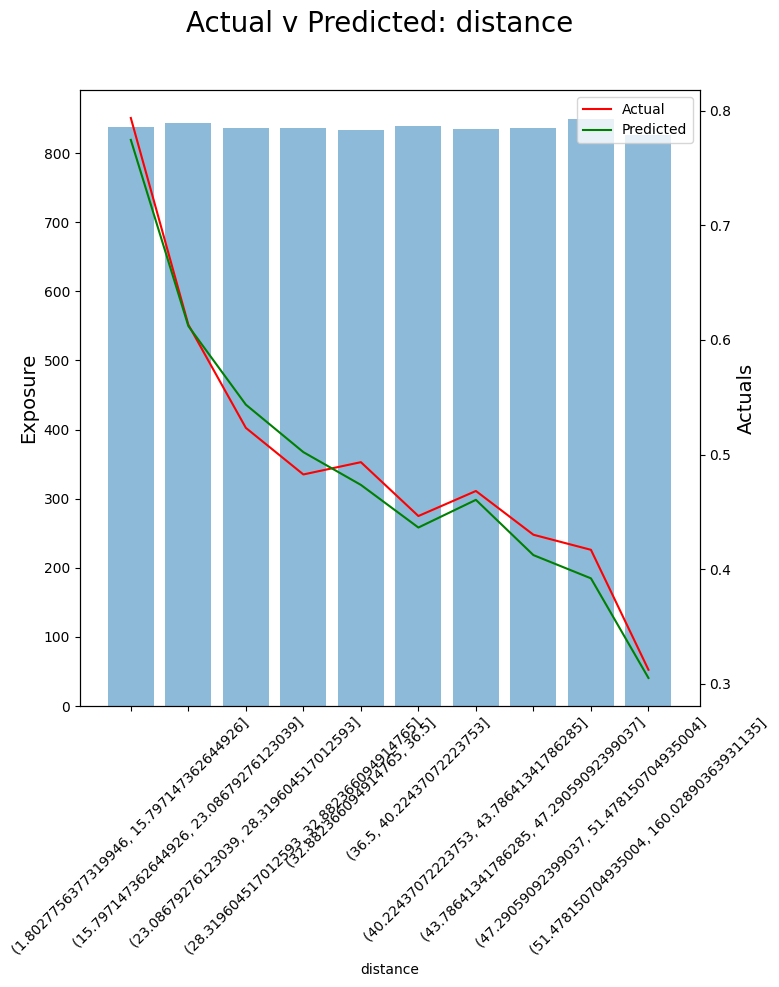

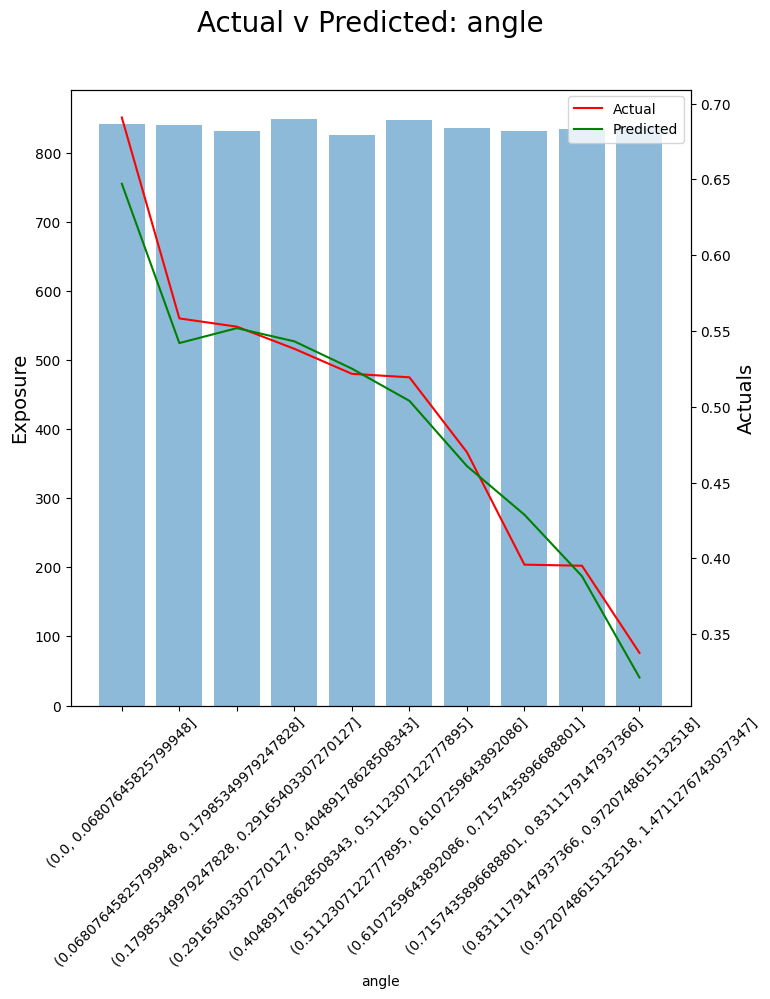

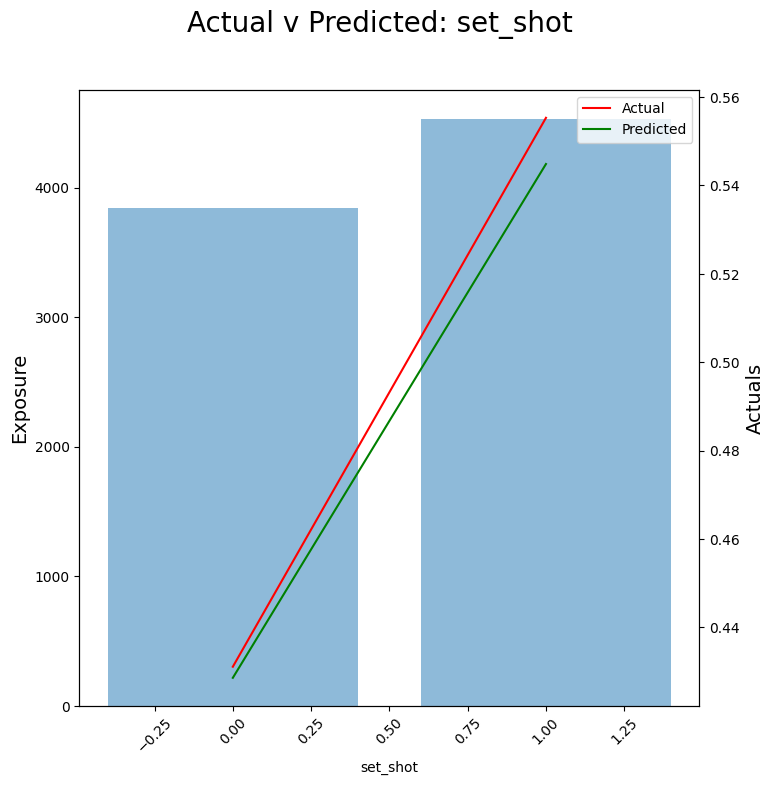

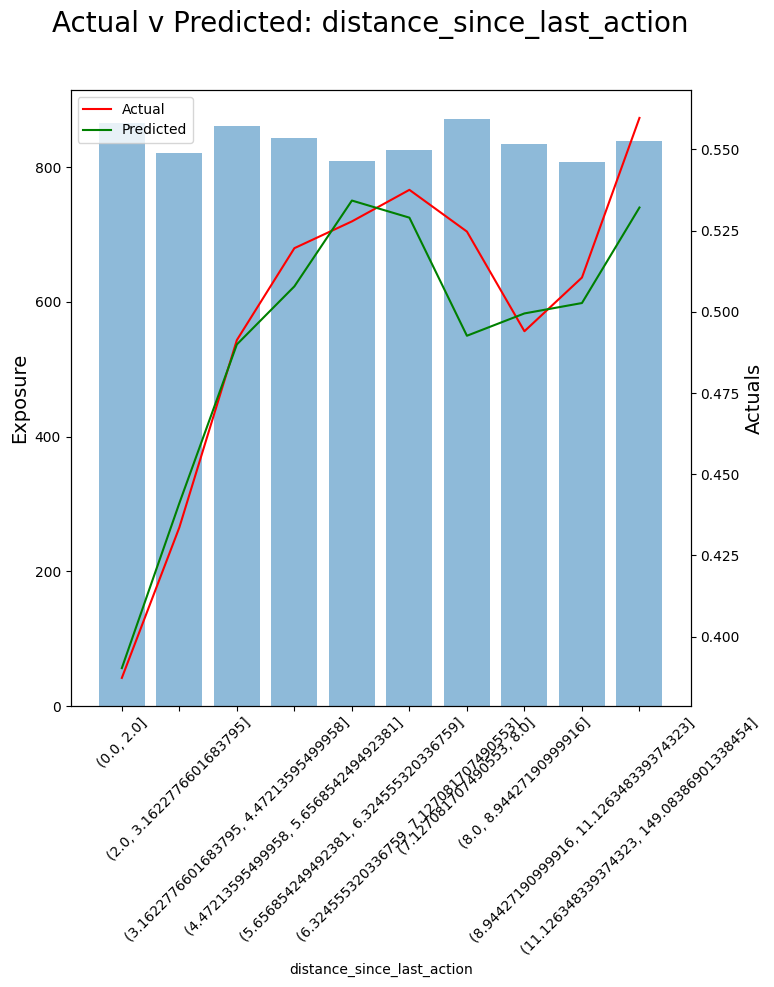

In [33]:
for feature in model.cb_clf.feature_names_:
    fig, ax = model_eval.plot_feature_ave(actual = goal, predicted = class_probabilities['predicted_proba_goal'], feature = X_test[feature], feature_name = feature)

Extra Features

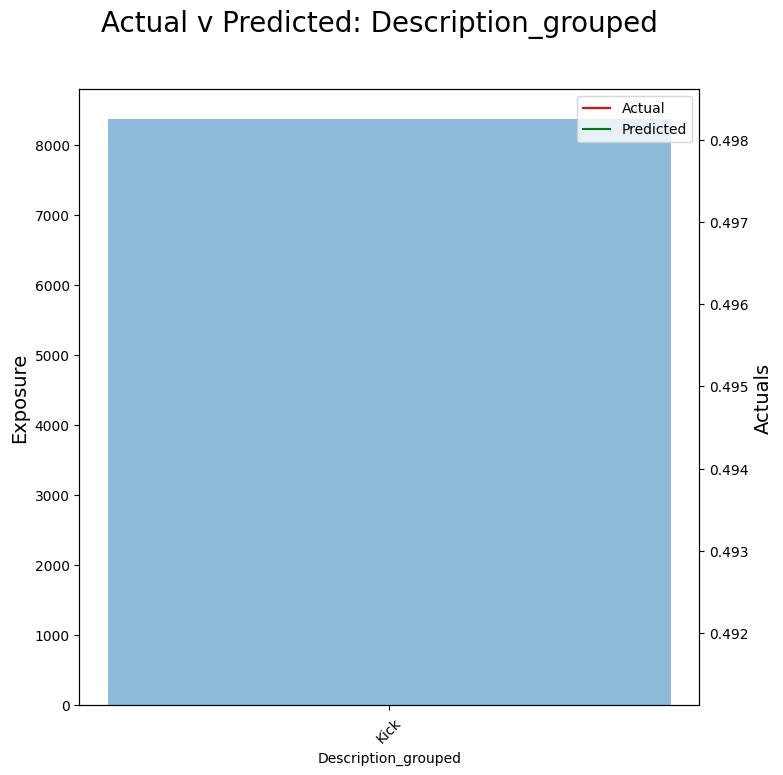

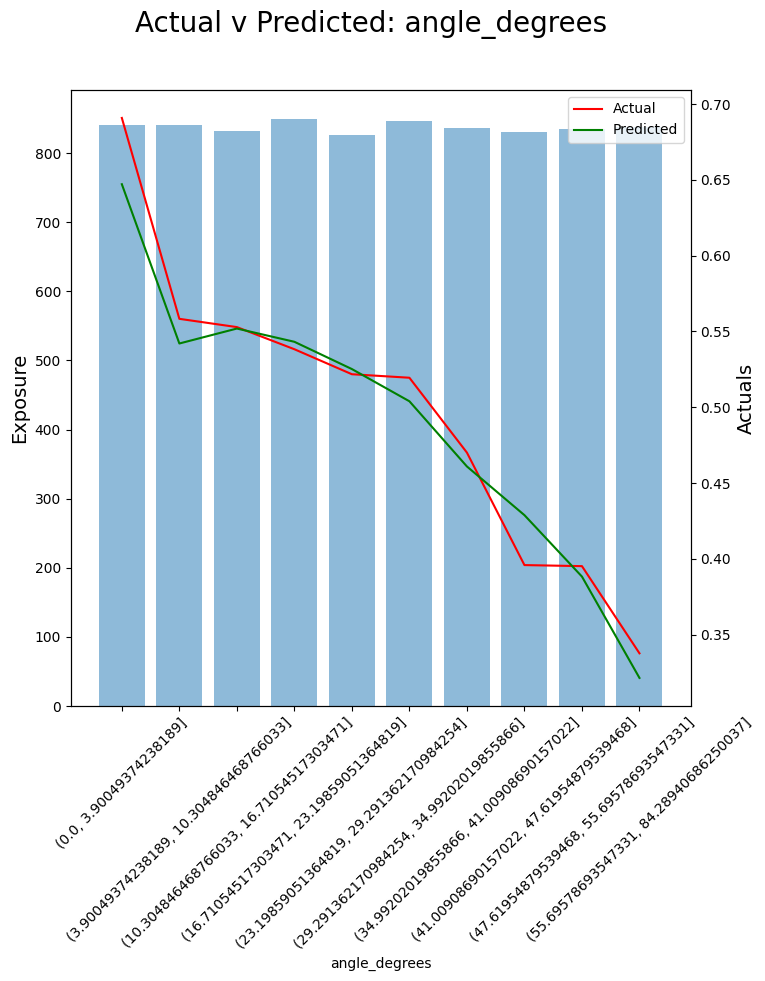

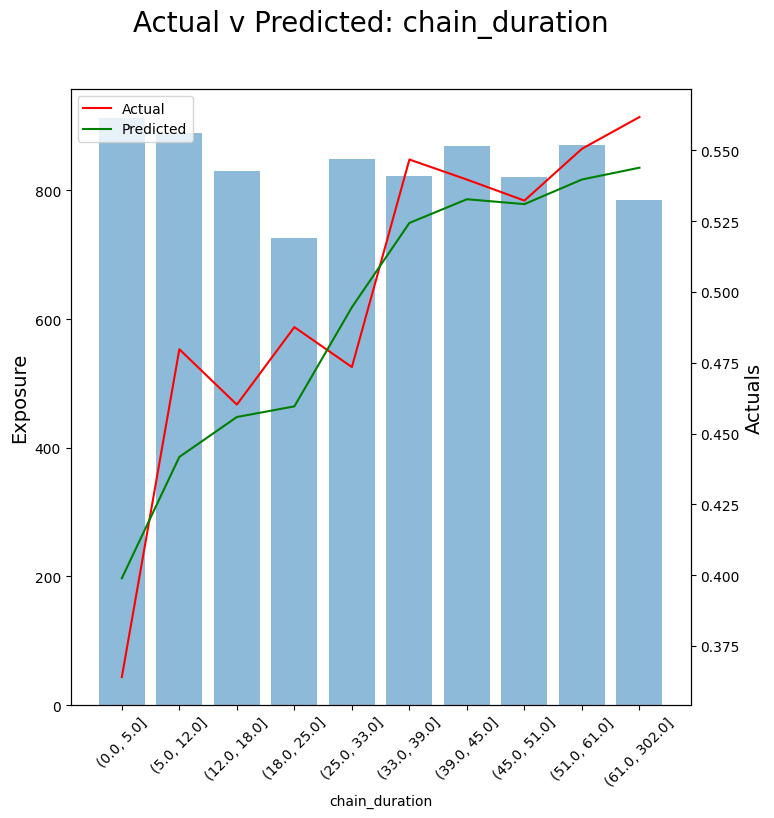

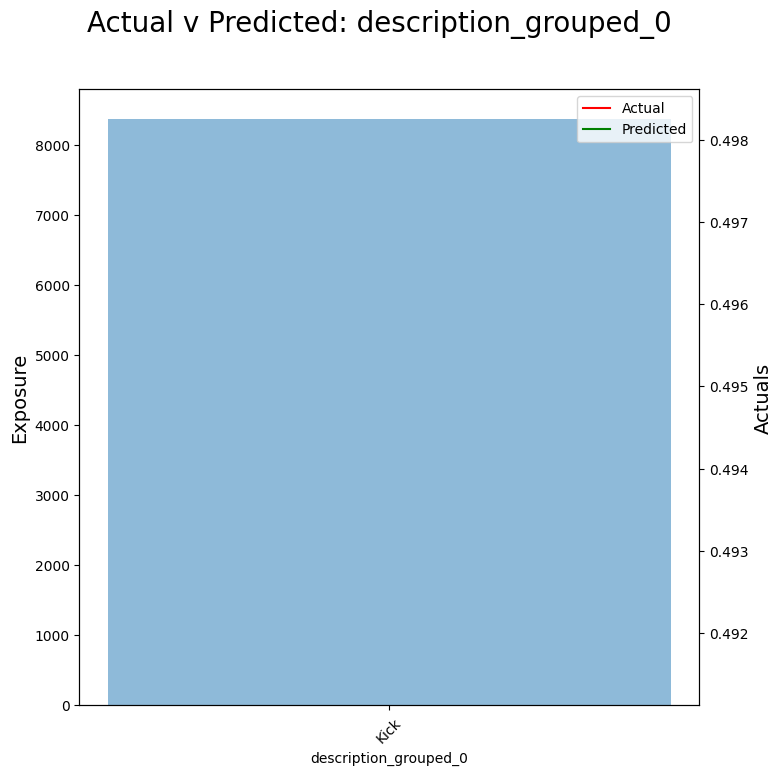

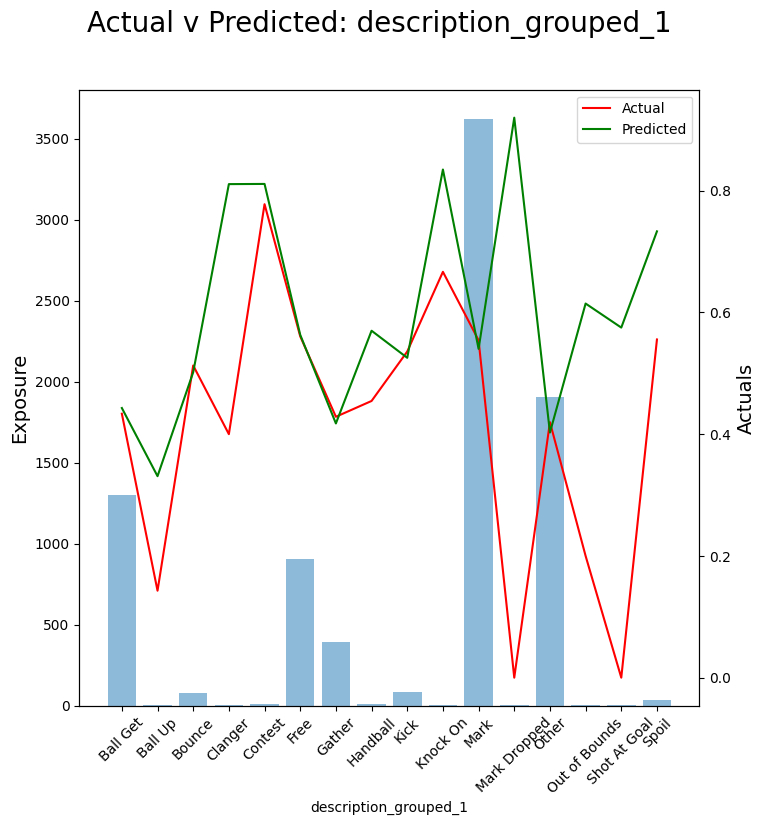

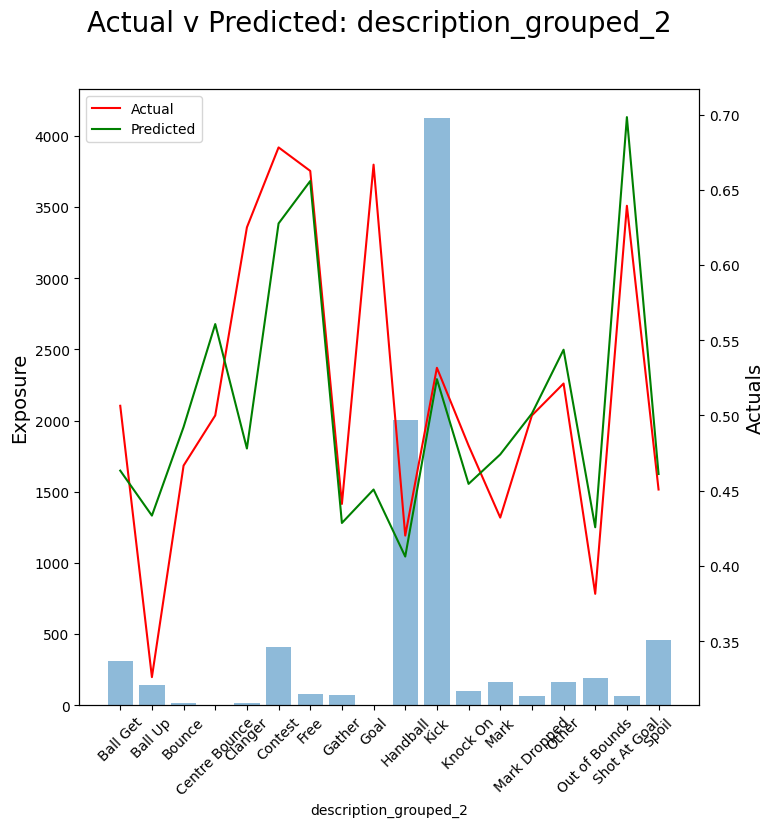

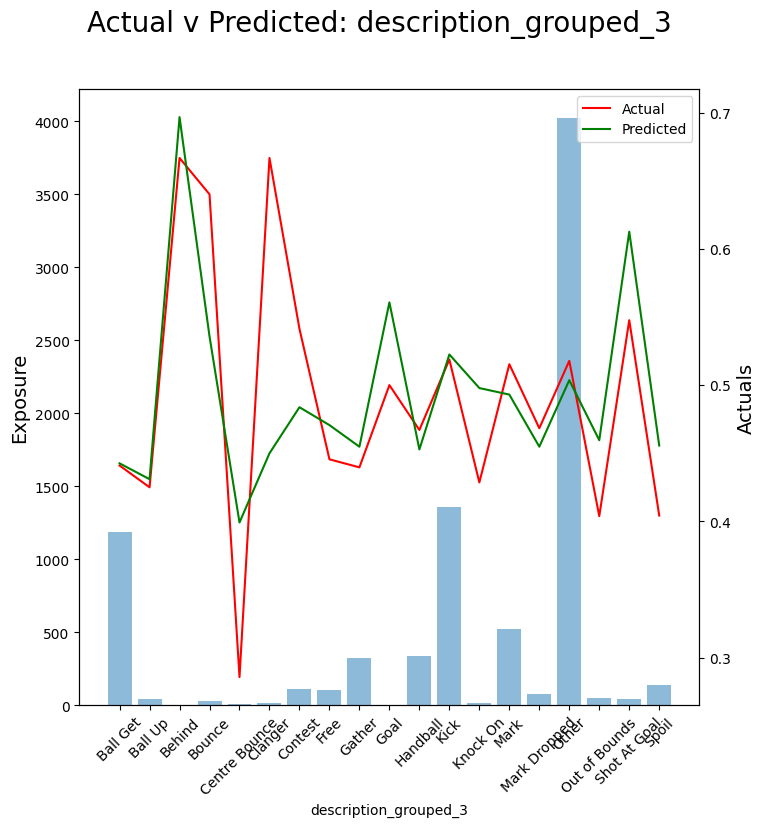

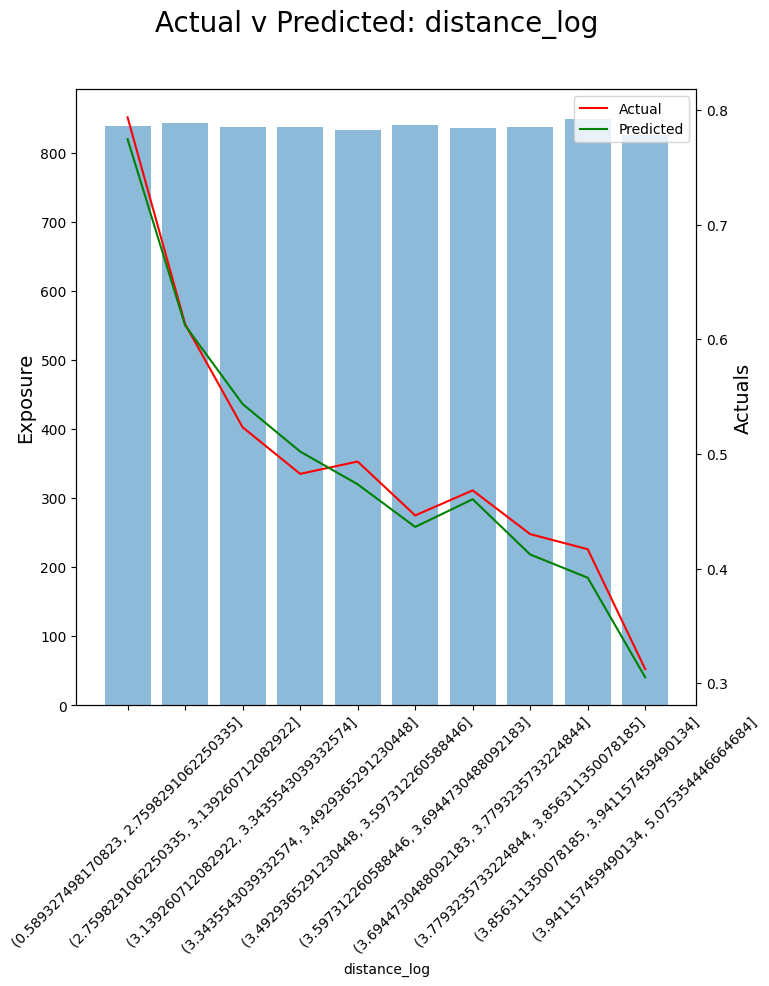

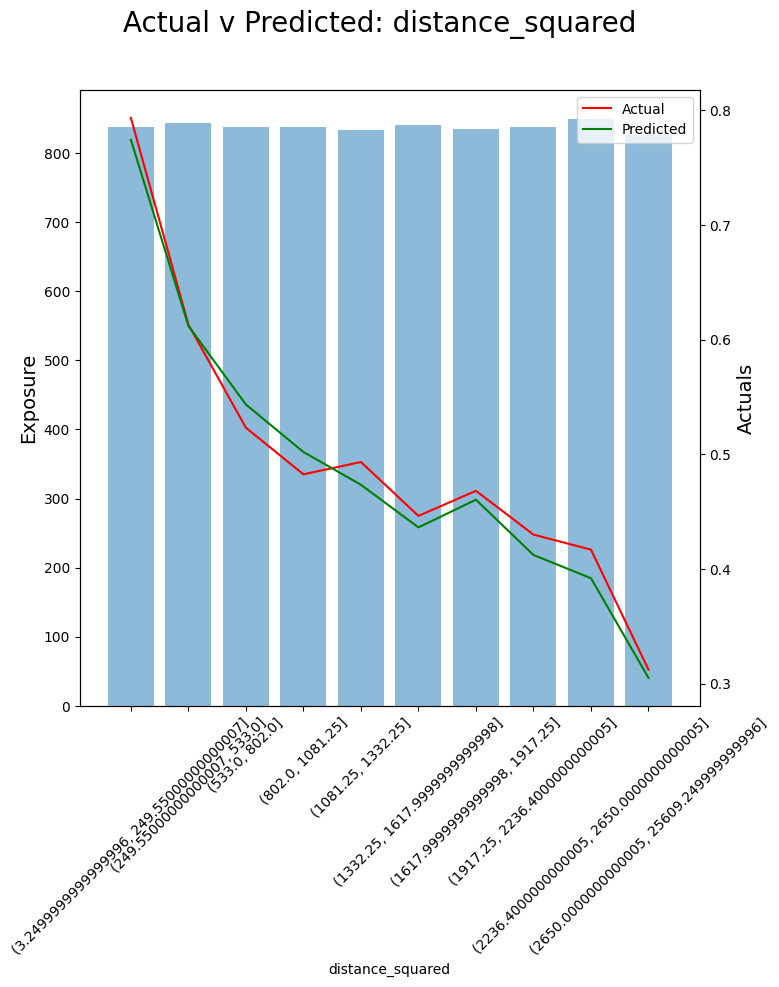

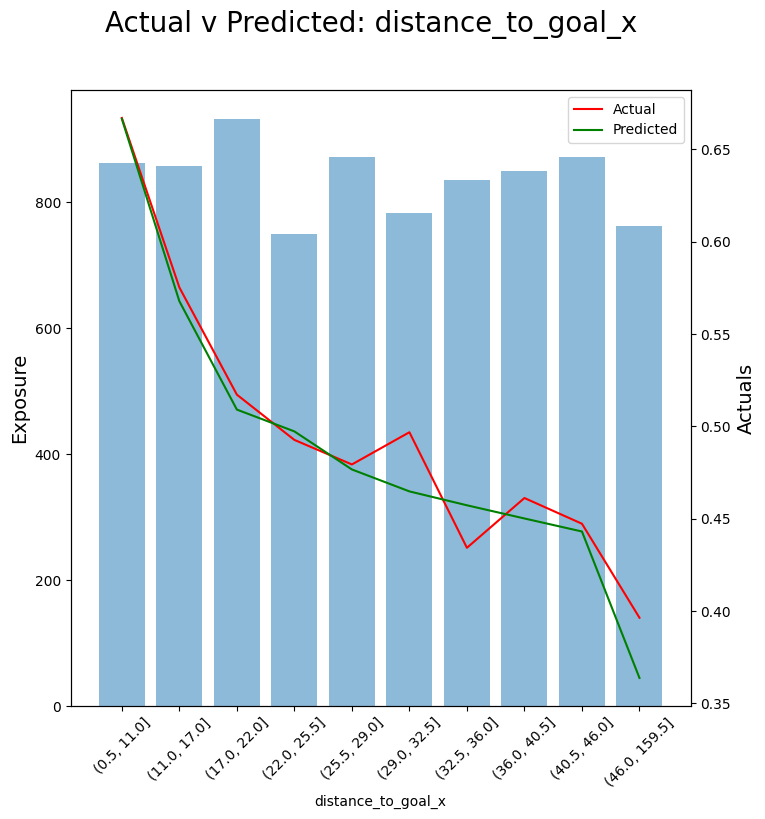

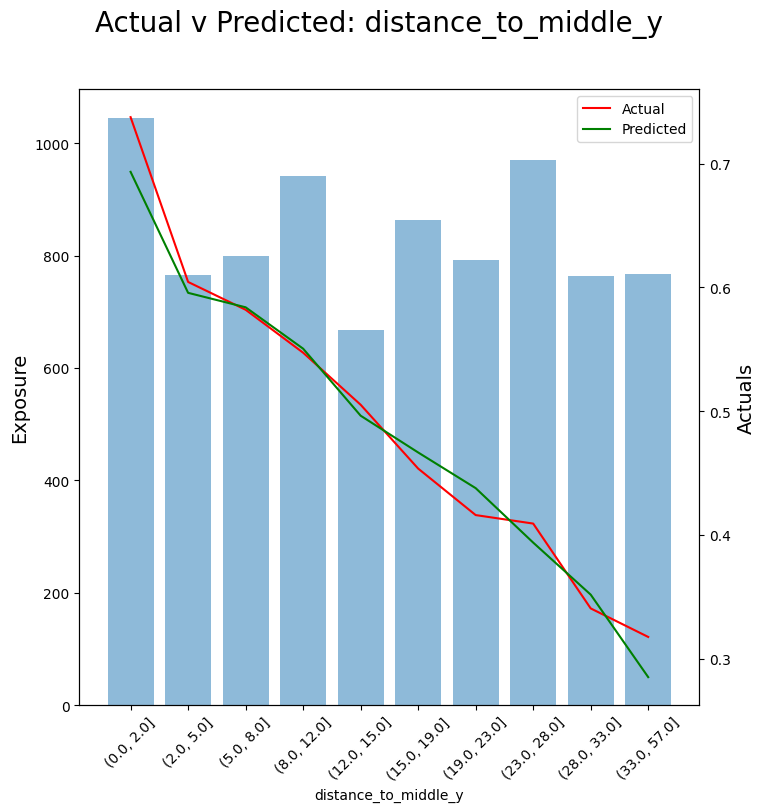

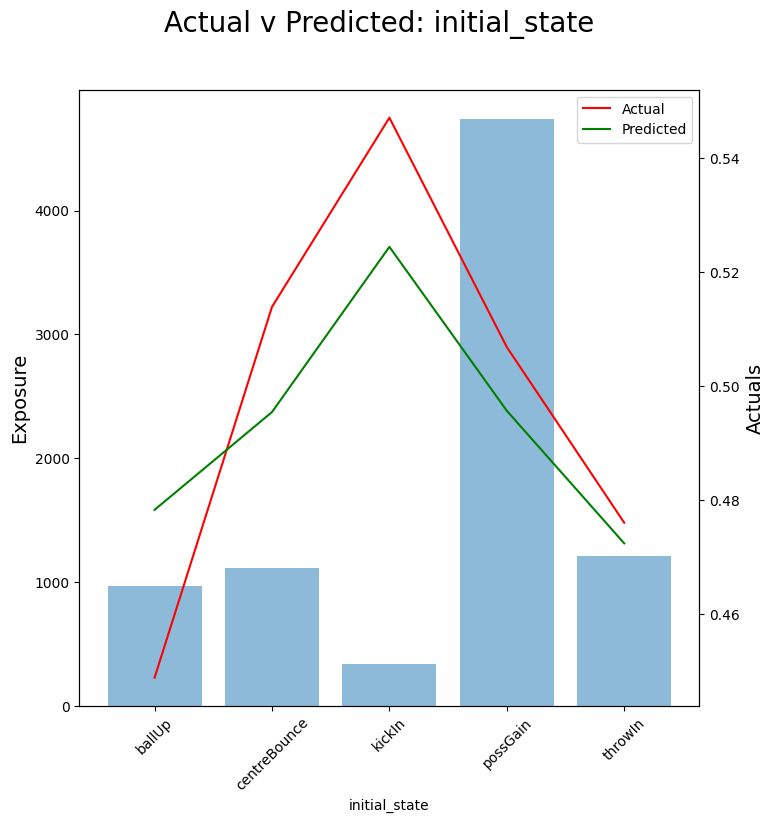

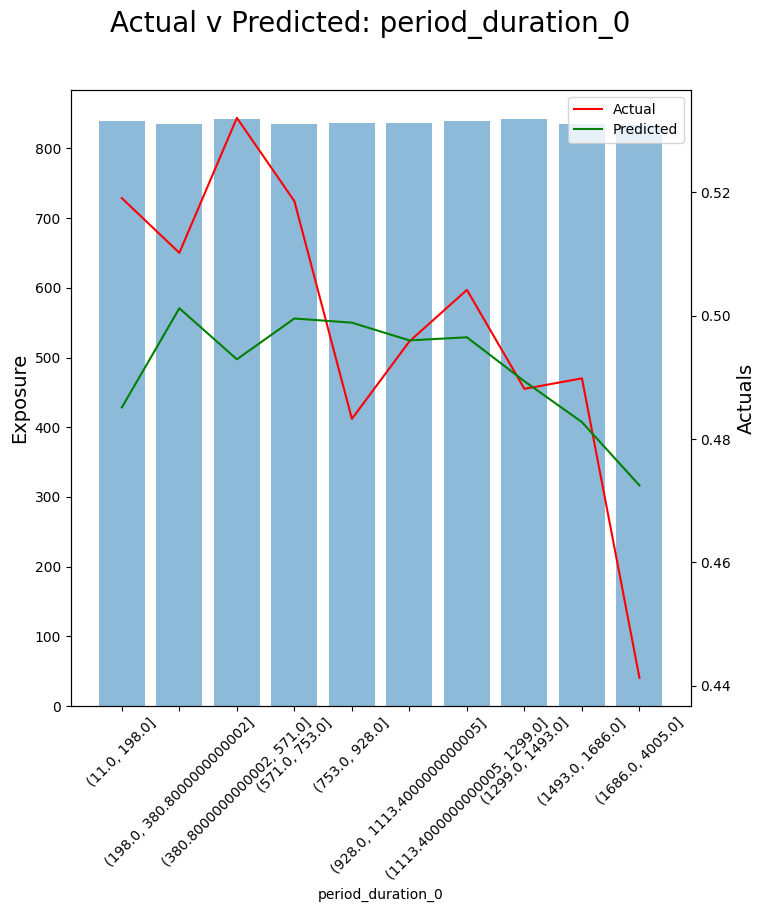

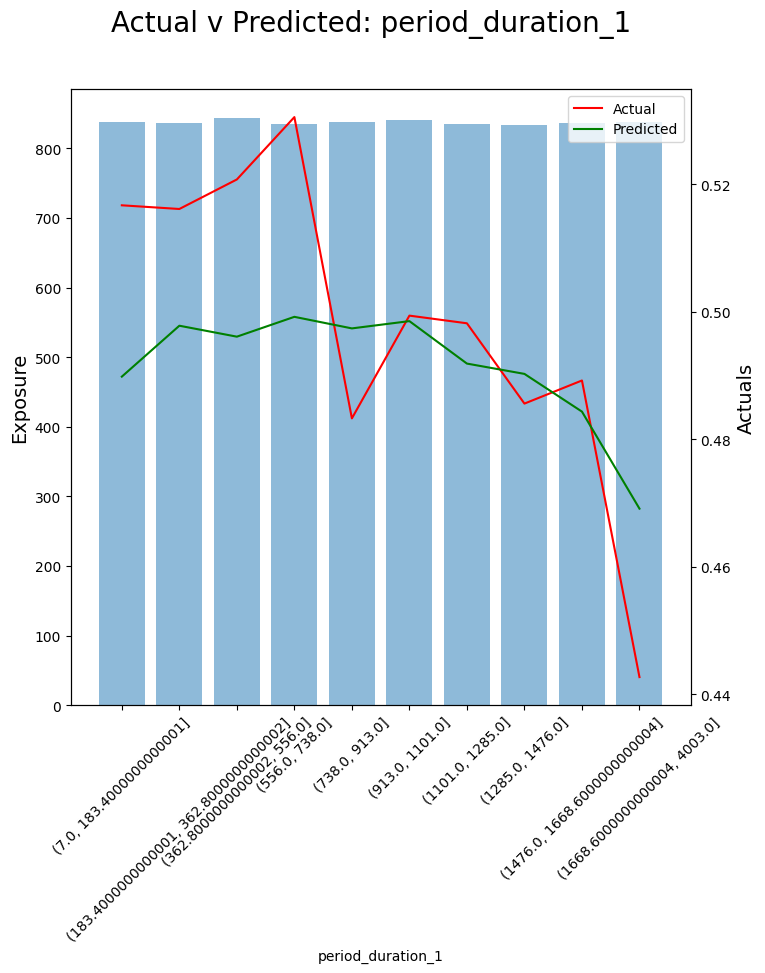

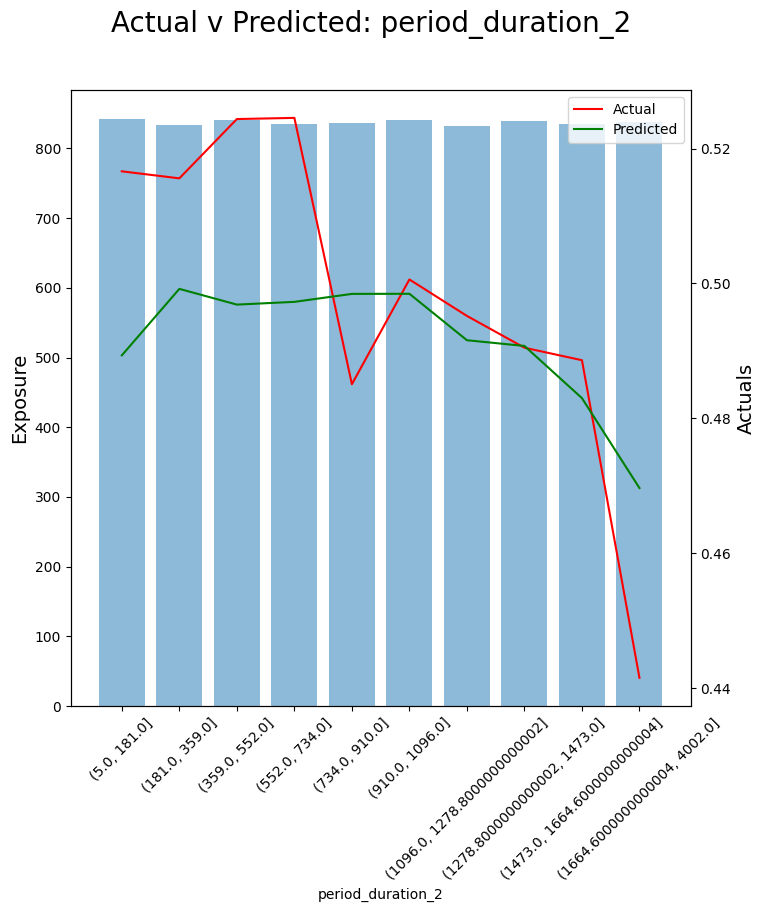

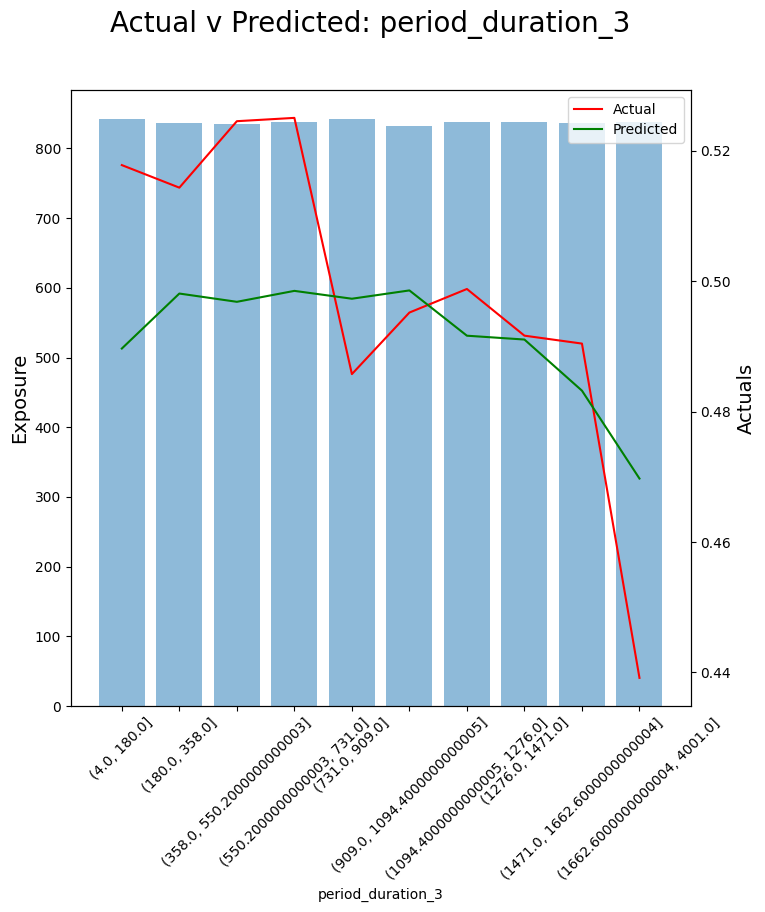

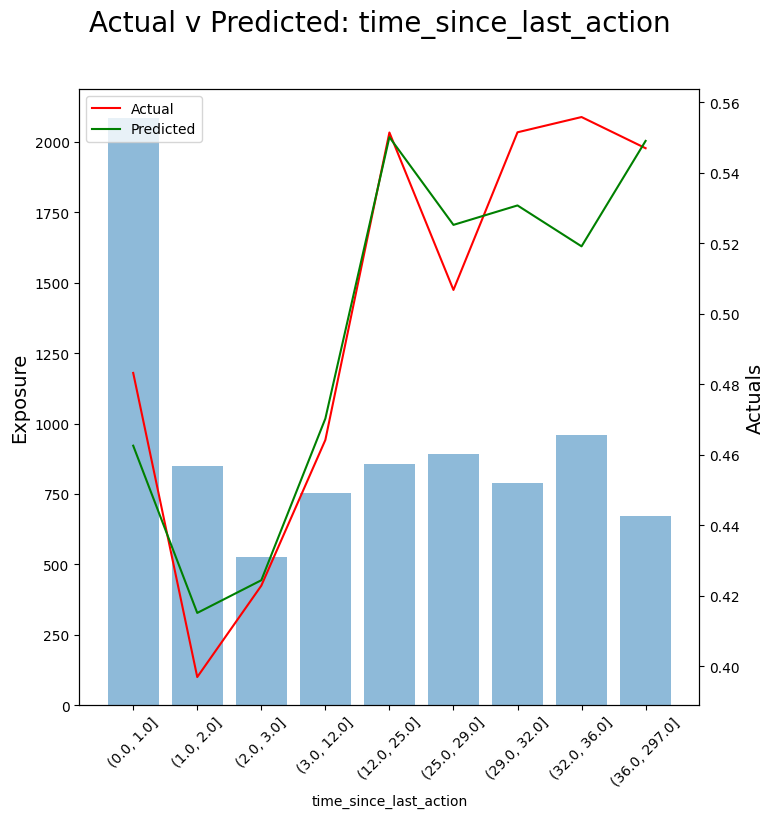

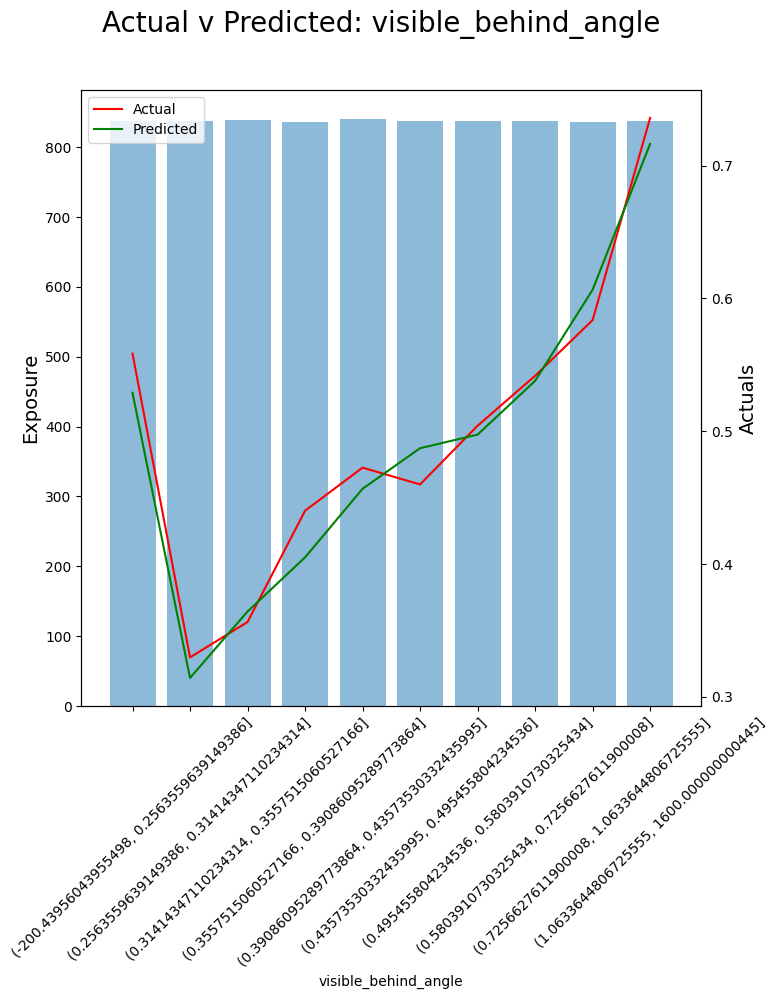

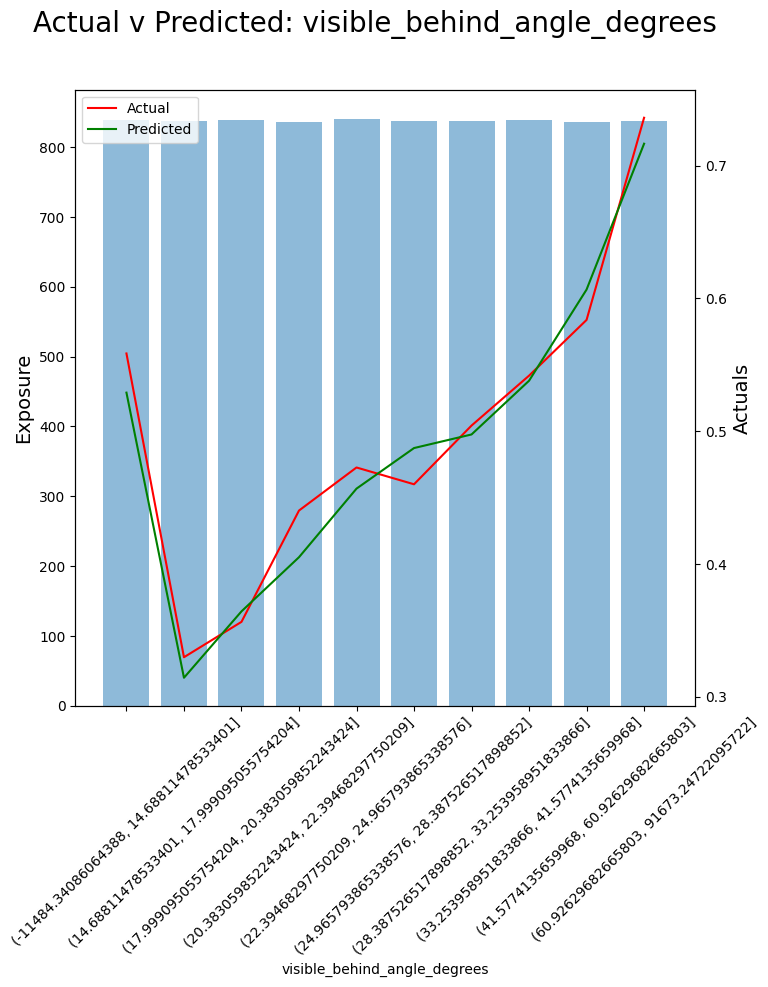

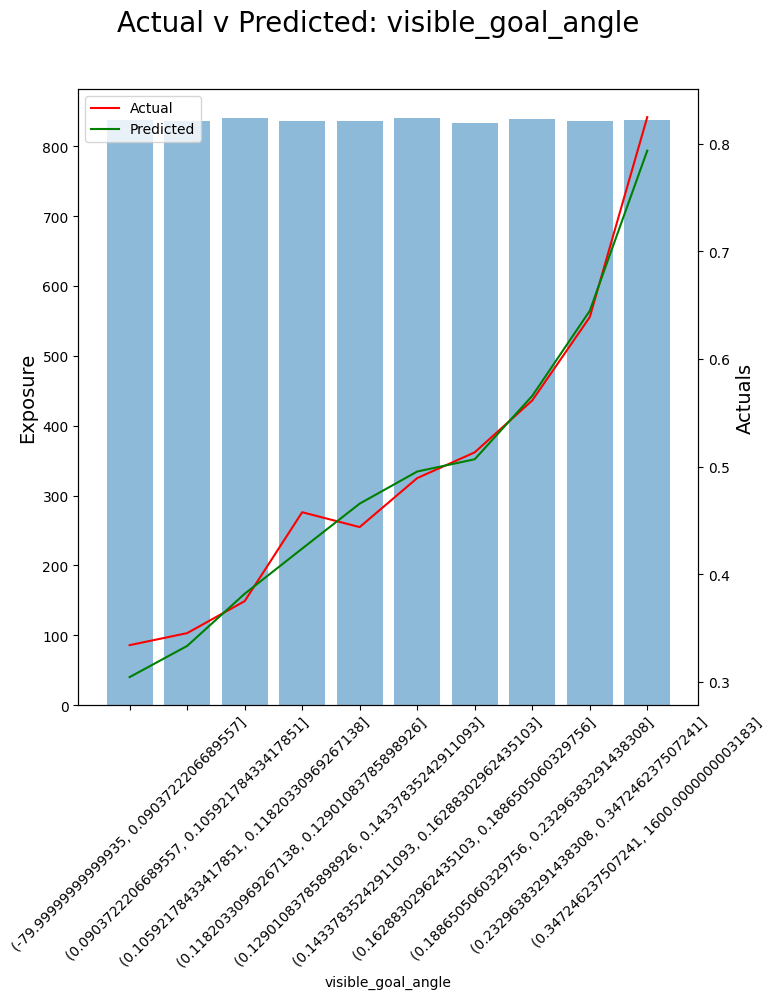

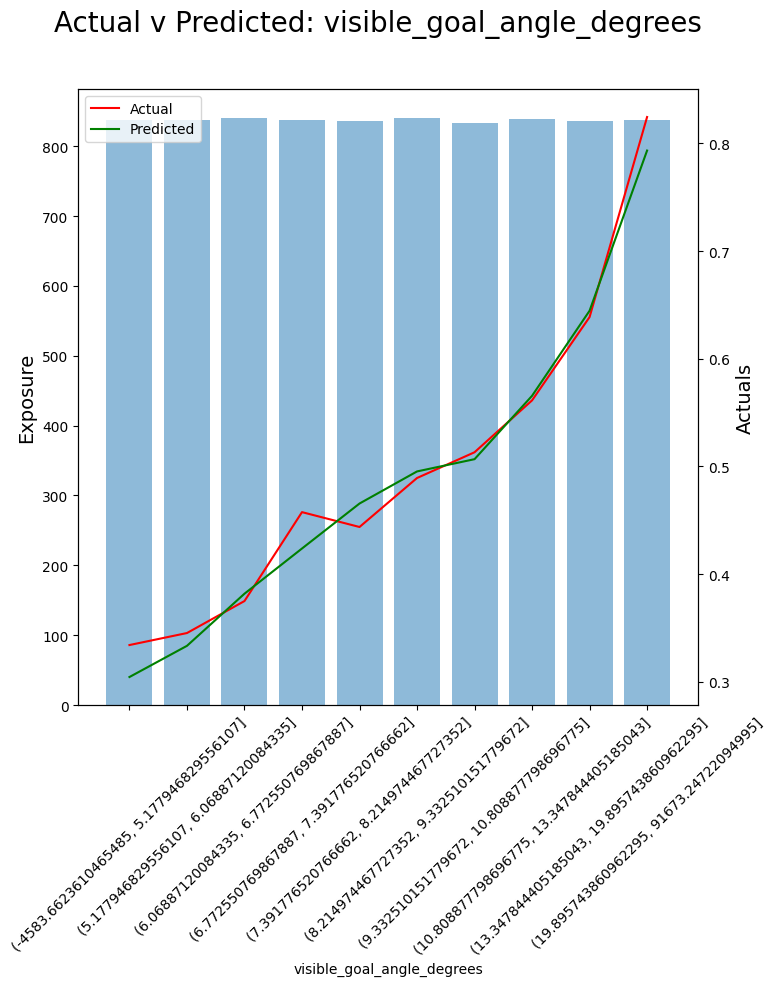

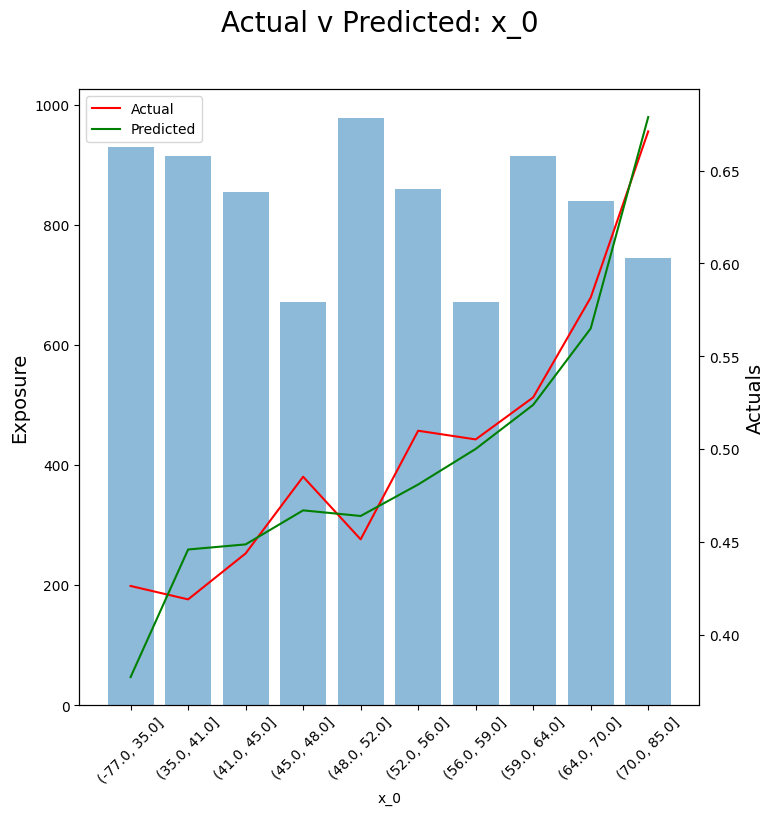

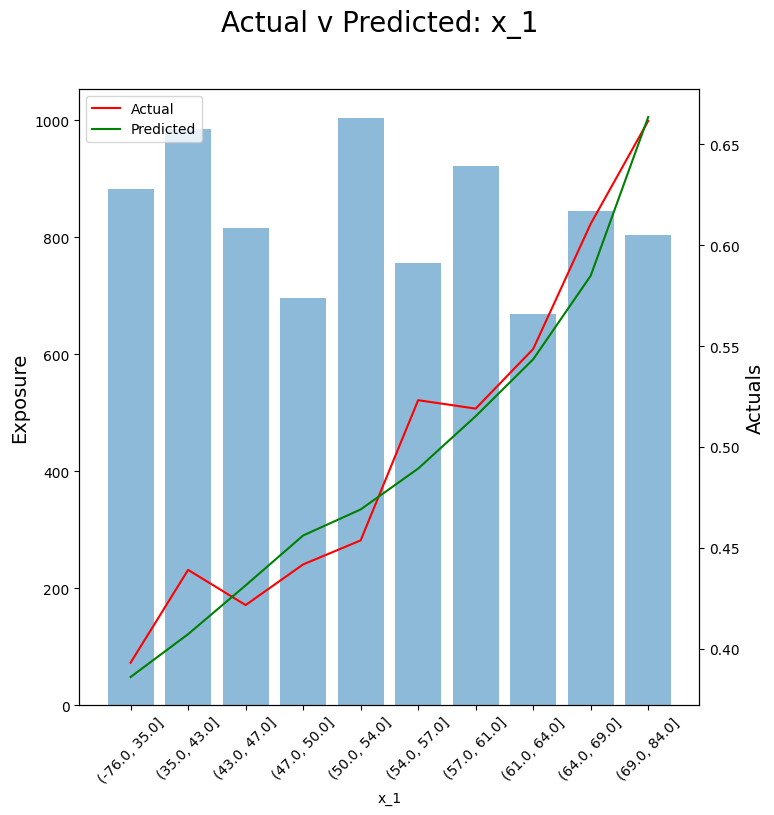

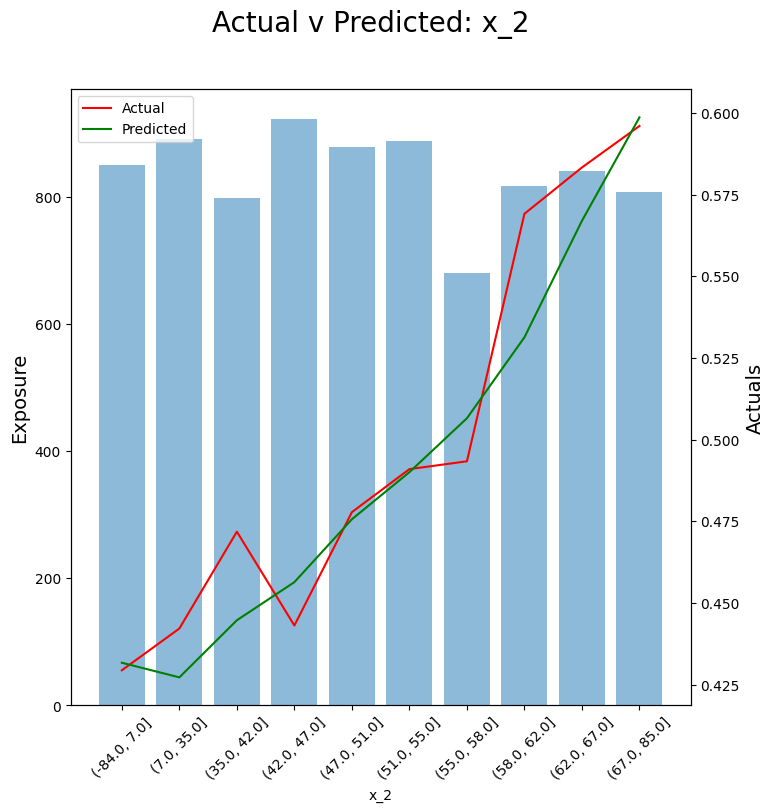

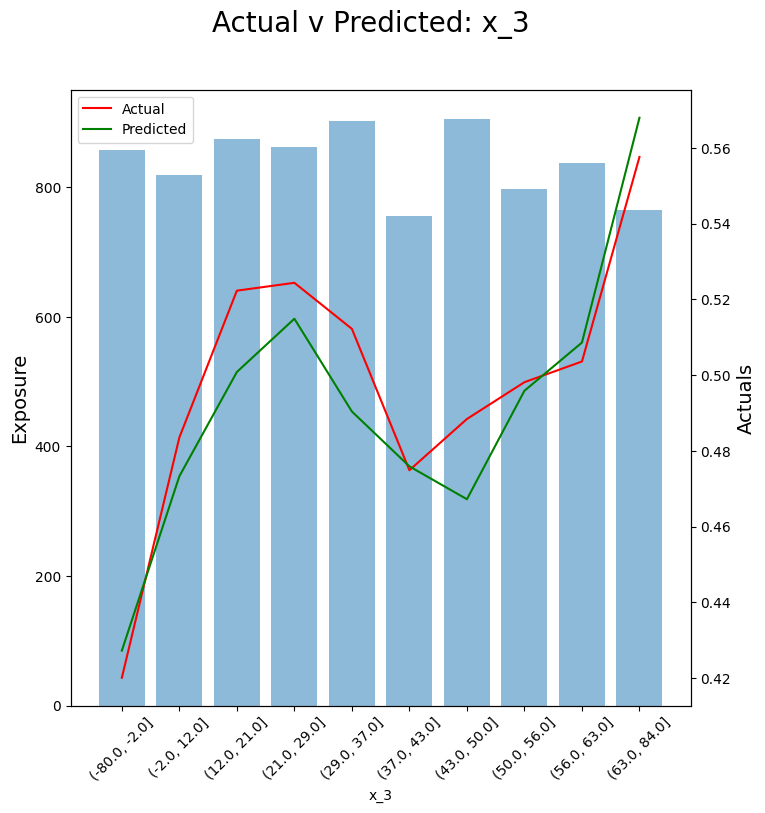

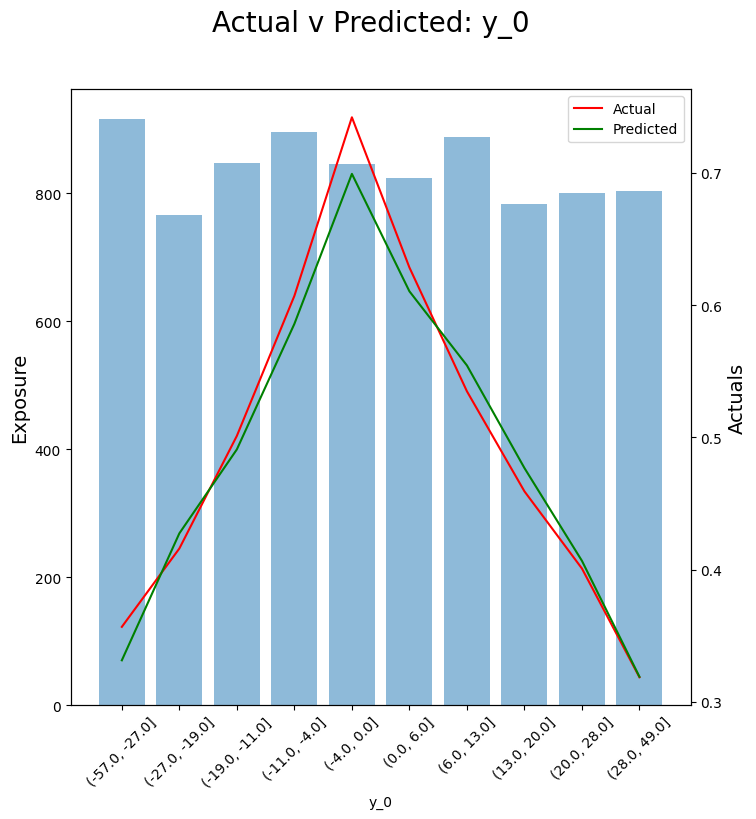

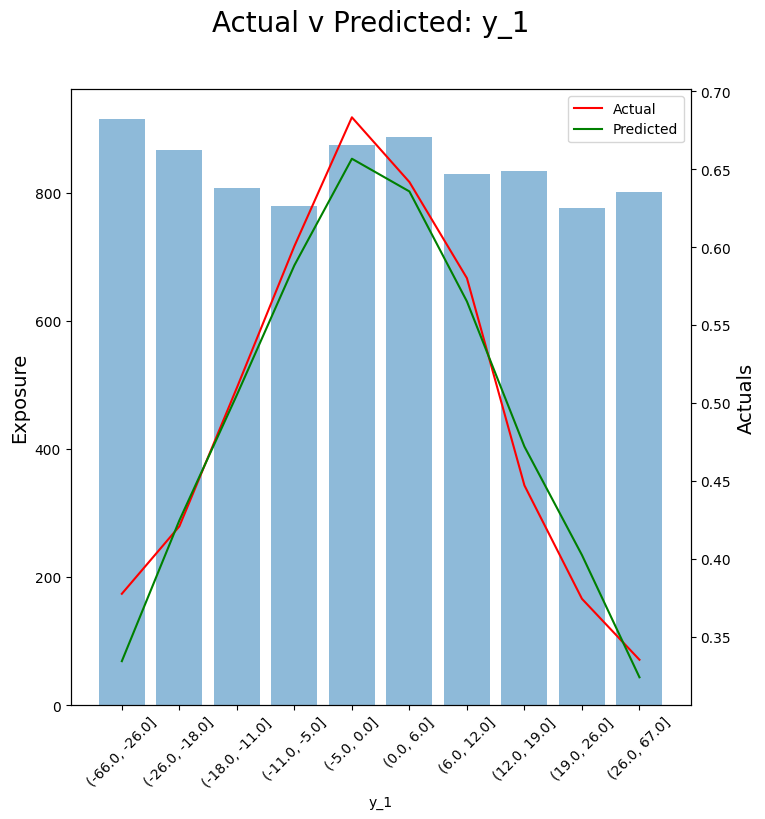

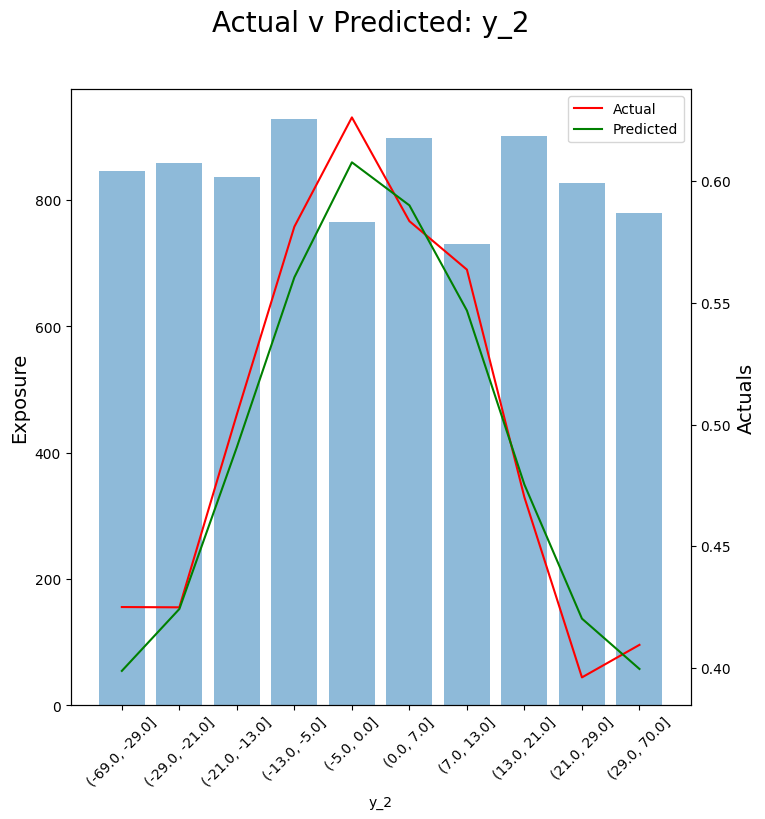

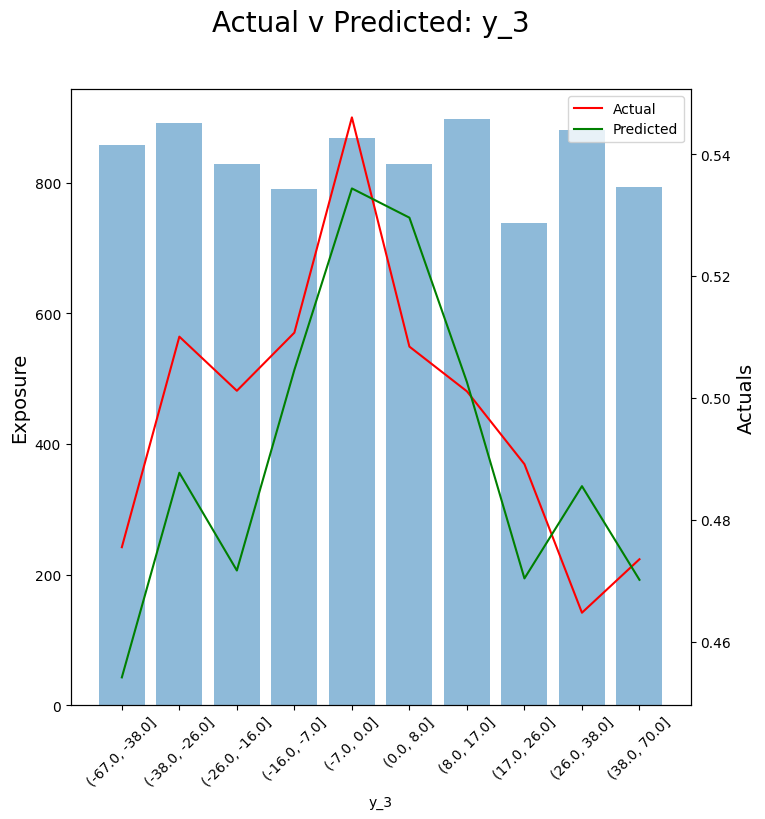

In [34]:
candidate_features = sorted(list(set(X_shots.columns) - set(X_shots_selected)))
for feature in candidate_features:
    fig, ax = model_eval.plot_feature_ave(actual = goal, predicted = class_probabilities['predicted_proba_goal'], feature = X_shots.loc[X_test.index][feature], feature_name = feature)

Classification

In [35]:
multi_class_model_eval = ClassificationModelEvaluator(model = model, classification_type='multi')

In [36]:
model.classes_

array(['behind', 'goal', 'miss'], dtype=object)

In [37]:
actual_label = y_test
predicted_label = predicted_result

In [38]:
multi_class_model_eval.get_log_loss(actual = actuals_binary, predictions = predicted_probabilities)

{'class_behind': 0.6157485002126095,
 'class_goal': 0.6067479440220335,
 'class_miss': 0.3818028585229122}

In [39]:
multi_class_model_eval.get_brier_score_loss(actual = actuals_binary, predictions = predicted_probabilities)

{'class_behind': 0.21551664042356702,
 'class_goal': 0.2109417594155842,
 'class_miss': 0.12016999785683209}

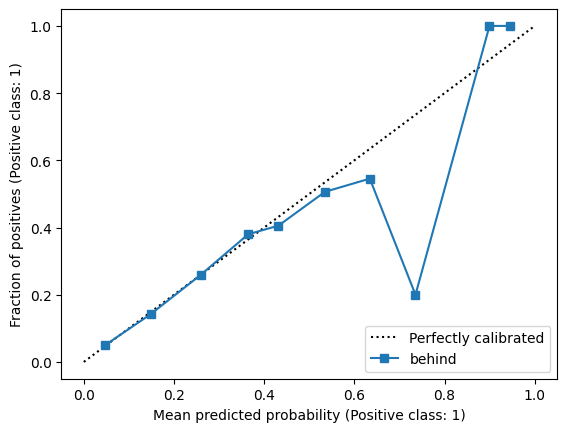

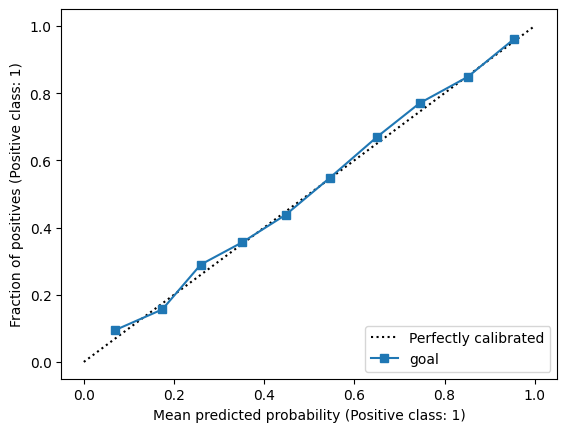

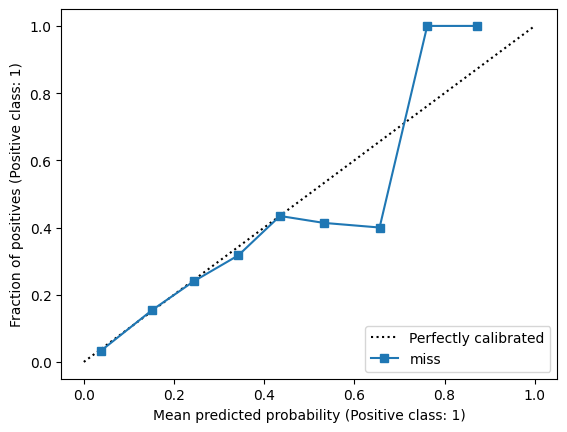

In [40]:
multi_class_model_eval.display_calibration_curve(actual = actuals_binary, predictions = predicted_probabilities, nbins=10) 

In [41]:
multi_class_model_eval.get_confusion_matrix(actual_label=actual_label, predicted_label=predicted_label)

array([[1162, 1572,  145],
       [ 953, 3111,  109],
       [ 747,  419,  157]])

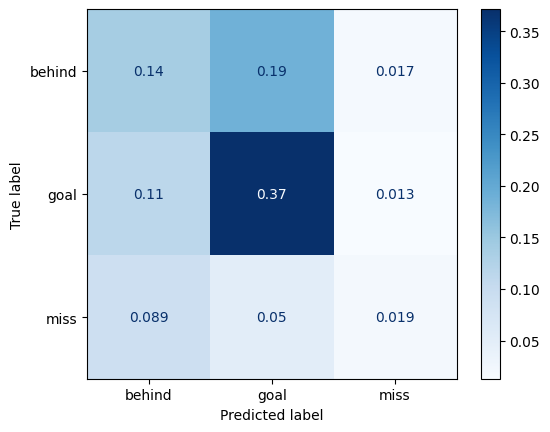

In [42]:
multi_class_model_eval.display_confusion_matrix(actual_label=actual_label, predicted_label=predicted_label)

In [43]:
specified_class = 'goal'
class_label = np.where(actual_label == specified_class, 1, 0)
predicted_class_label = np.where(predicted_label == specified_class, 1, 0)

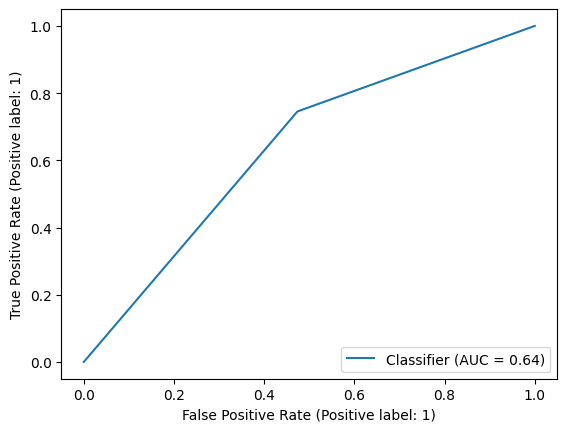

In [44]:
multi_class_model_eval.plot_roc_curve(actual_label=class_label, predicted_label=predicted_class_label)

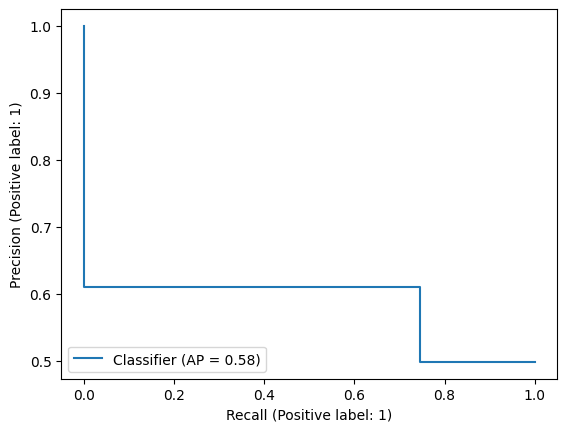

In [45]:
multi_class_model_eval.plot_prauc_curve(actual_label=class_label, predicted_label=predicted_class_label)

In [46]:
regression_model_eval = RegressionModelEvaluator(model = model)

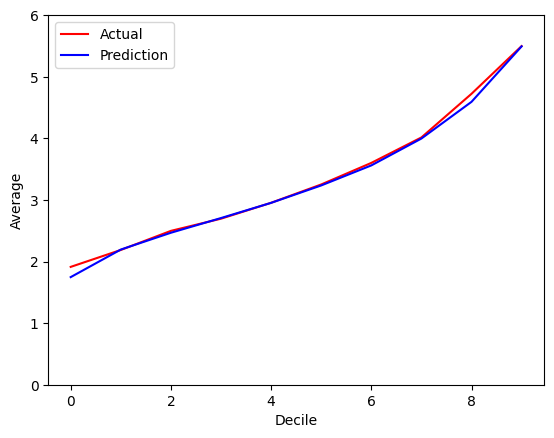

In [47]:
fig, ax = regression_model_eval.plot_decile(actual = score, predictions = predicted_score)

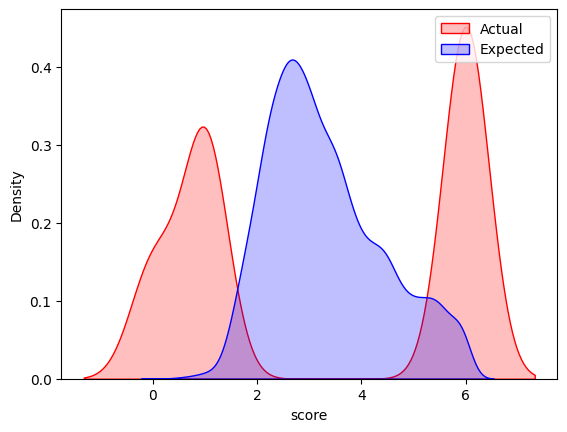

In [48]:
fig, ax = regression_model_eval.plot_distribution(actual = score, predictions = predicted_score)

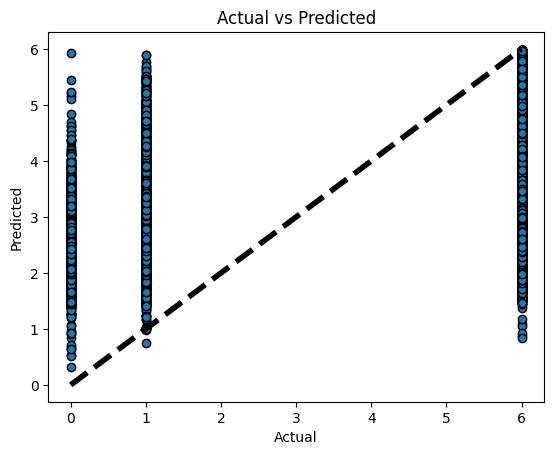

In [49]:
fig, ax = regression_model_eval.plot_ave(actual = score, predictions = predicted_score)

CatBoost Evaluation

In [51]:
cb_model_evaluator = CatBoostEvaluator(
    catboost_model = model.cb_clf,
    evaluator = ClassificationModelEvaluator
)   

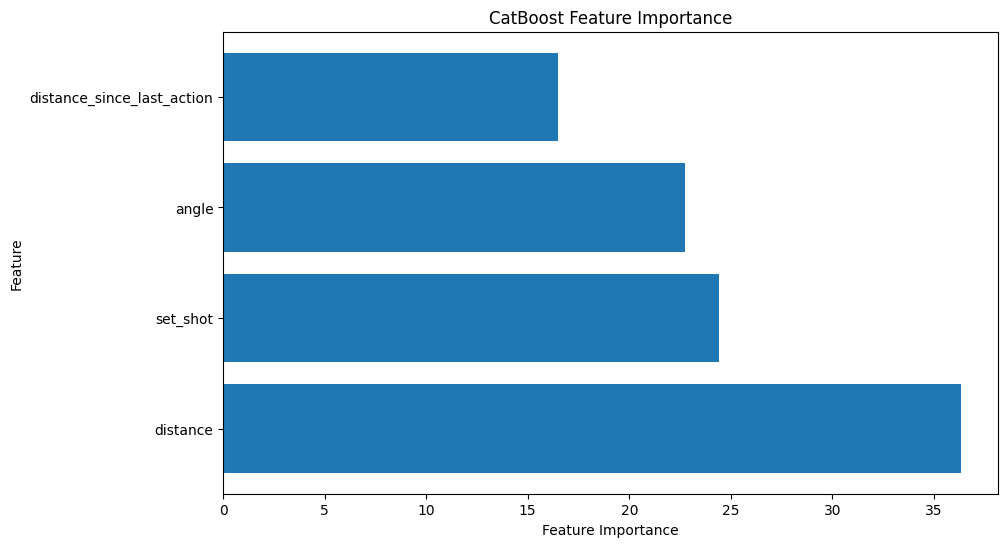

In [52]:
fig, ax = cb_model_evaluator.plot_feature_importance()

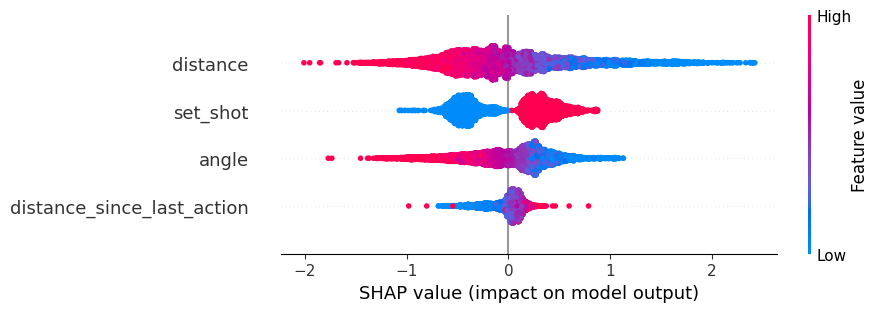

In [53]:
cb_model_evaluator.plot_shap_beeswarm(X_test, y_test, specified_class='goal', max_display=10)

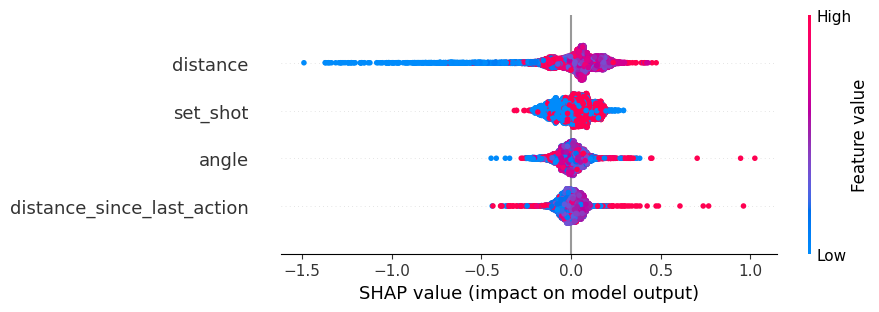

In [54]:
cb_model_evaluator.plot_shap_beeswarm(X_test, y_test, specified_class='behind', max_display=10)

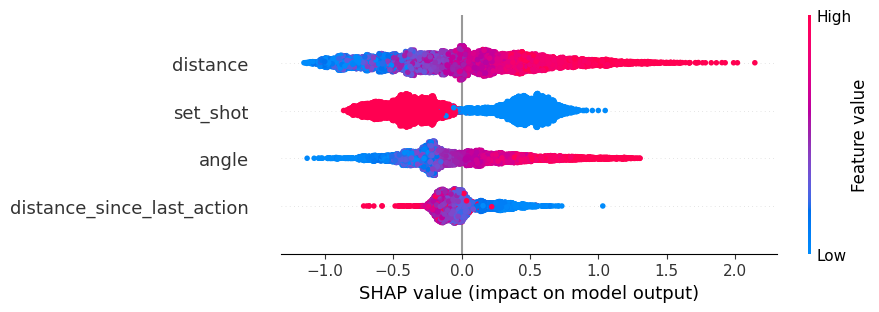

In [55]:
cb_model_evaluator.plot_shap_beeswarm(X_test, y_test, specified_class='miss', max_display=10)

Export (or Upload) Predictions

In [56]:
shots = chains.loc[X_shots.index]
shots['predicted_result'] = model.predict(X_shots[selected_features]).flatten()
shots[[f'{x}_probas' for x in model.classes_]] = model.predict_proba(X_shots[selected_features])
shots['xscore'] = shots['goal_probas']*6 + shots['behind_probas']
shots = pd.concat([shots, X_shots], axis=1)
shots.head()

CD_Player_ID  Chain_Number Team_Chain Initial_State Final_State  \
47    CD_I990609             5   Brisbane      possGain      behind   
111   CD_I294518            12   Brisbane      possGain      behind   
195  CD_I1006126            22     Sydney       throwIn      behind   
206   CD_I997100            24     Sydney      possGain        goal   
217   CD_I996765            25     Sydney  centreBounce        goal   

     Period_Number  Period_Duration_Chain_Start Description     Disposal  \
47             1.0                         50.0        Kick  ineffective   
111            1.0                        270.0        Kick  ineffective   
195            1.0                        550.0        Kick  ineffective   
206            1.0                        576.0        Kick    effective   
217            1.0                        659.0        Kick    effective   

    Shot_At_Goal Behind_Detail  Order  Period_Duration     x     y Home_Team  \
47          TRUE           NaN   48.0            118.0  44.0  12.0    Sydney   
111         TRUE           NaN  112.0            327.0  56.0 -33.0    Sydney   
195         TRUE           NaN  196.0            558.0  64.0  15.0    Sydney   
206         TRUE           NaN  207.0            596.0  58.0 -21.0    Sydney   
217         TRUE           NaN  218.0            677.0  51.0  28.0    Sydney   

    Away_Team Home_Team_Direction_Q1  Venue_Width  Venue_Length  \
47   Brisbane                  right        141.0         160.0   
111  Brisbane                  right        141.0         160.0   
195  Brisbane                  right        141.0         160.0   
206  Brisbane                  right        141.0         160.0   
217  Brisbane                  right        141.0         160.0   

              Player      Team                     Match_ID        Player_ID  \
47   Charlie Cameron  Brisbane  AFL_2024_F4_Sydney_Brisbane  charlie_cameron   
111      Joe Daniher  Brisbane  AFL_2024_F4_Sydney_Brisbane      joe_daniher   
195  James Rowbottom    Sydney  AFL_2024_F4_Sydney_Brisbane  james_rowbottom   
206     Will Hayward    Sydney  AFL_2024_F4_Sydney_Brisbane     will_hayward   
217       Tom Papley    Sydney  AFL_2024_F4_Sydney_Brisbane       tom_papley   

     result  score  miss  behind  goal predicted_result  behind_probas  \
47   behind      1     0       1     0             goal       0.319560   
111  behind      1     0       1     0             goal       0.390387   
195  behind      1     0       1     0             goal       0.366333   
206    goal      6     0       0     1             goal       0.352048   
217    goal      6     0       0     1           behind       0.477895   

     goal_probas  miss_probas    xscore Description_grouped     angle  \
47      0.662595     0.017846  4.295127                Kick  0.321751   
111     0.457245     0.152368  3.133859                Kick  0.942000   
195     0.484895     0.148772  3.275702                Kick  0.753151   
206     0.608978     0.038974  4.005918                Kick  0.762147   
217     0.293154     0.228950  2.236821                Kick  0.767856   

     angle_degrees  chain_duration description_grouped_0  \
47       18.434949            68.0                  Kick   
111      53.972627            57.0                  Kick   
195      43.152390             8.0                  Kick   
206      43.667780            20.0                  Kick   
217      43.994914            18.0                  Kick   

    description_grouped_1 description_grouped_2 description_grouped_3  \
47                   Mark                  Kick                 Other   
111                  Mark                  Kick                 Other   
195              Ball Get                Gather              Knock On   
206                  Free                  Free                  Kick   
217                 Other              Handball                Gather   

      distance  distance_log  distance_since_last_action  distance_squa

In [66]:
upload_data(Dataset = shots, Dataset_Name="CG_Expected_Score", overwrite=True, update_if_identical=True)

In [67]:
xscore_data = load_data(Dataset_Name="CG_Expected_Score", ID = "AFL")
xscore_data.head()

CD_Player_ID  Chain_Number Team_Chain Initial_State Final_State  \
0  CD_I1000978             8   Brisbane      possGain        goal   
1  CD_I1000953            14    Carlton      possGain        goal   
2  CD_I1002235            18   Brisbane      possGain        goal   
3   CD_I261224            25   Brisbane       throwIn        goal   
4   CD_I261224            27   Brisbane      possGain        goal   

   Period_Number  Period_Duration_Chain_Start  Description   Disposal  \
0            1.0                        139.0         Kick  effective   
1            1.0                        328.0         Kick  effective   
2            1.0                        483.0         Kick  effective   
3            1.0                        682.0  Ground Kick  effective   
4            1.0                        876.0         Kick  effective   

   Shot_At_Goal Behind_Detail  Order  Period_Duration     x     y Home_Team  \
0          True           NaN   61.0            183.0  58.0 -43.0  Brisbane   
1          True           NaN  111.0            385.0  37.0   7.0  Brisbane   
2          True           NaN  146.0            497.0  73.0  -4.0  Brisbane   
3          True           NaN  210.0            751.0  64.0   3.0  Brisbane   
4          True           NaN  227.0            907.0  61.0 -25.0  Brisbane   

  Away_Team Home_Team_Direction_Q1  Venue_Width  Venue_Length  \
0   Carlton                  right        138.0         156.0   
1   Carlton                  right        138.0         156.0   
2   Carlton                  right        138.0         156.0   
3   Carlton                  right        138.0         156.0   
4   Carlton                  right        138.0         156.0   

            Player      Team                      Match_ID        Player_ID  \
0  Hugh McCluggage  Brisbane  AFL_2024_00_Brisbane_Carlton  hugh_mccluggage   
1      Harry McKay   Carlton  AFL_2024_00_Brisbane_Carlton      harry_mckay   
2       Cam Rayner  Brisbane  AFL_2024_00_Brisbane_Carlton       cam_rayner   
3      Dayne Zorko  Brisbane  AFL_2024_00_Brisbane_Carlton      dayne_zorko   
4      Dayne Zorko  Brisbane  AFL_2024_00_Brisbane_Carlton      dayne_zorko   

  result  score  miss  behind  goal predicted_result  behind_probas  \
0   goal      6     0       0     1             miss       0.272966   
1   goal      6     0       0     1             goal       0.315075   
2   goal      6     0       0     1             goal       0.059792   
3   goal      6     0       0     1             goal       0.347254   
4   goal      6     0       0     1             goal       0.403359   

   goal_probas  miss_probas    xscore Description_grouped     angle  \
0     0.311027     0.416007  2.139129                Kick  1.135443   
1     0.662386     0.022539  4.289389                Kick  0.169101   
2     0.922198     0.018011  5.592977                Kick  0.674741   
3     0.535427     0.117319  3.559815                Kick  0.211093   
4     0.519147     0.077495  3.518238                Kick  0.973620   

   angle_degrees  chain_duration description_grouped_0 description_grouped_1  \
0      65.056095            44.0                  Kick                  Mark   
1       9.688787            57.0                  Kick                  Mark   
2      38.659808            14.0                  Kick                  Mark   
3      12.094757            69.0                  Kick                  Kick   
4      55.784298            31.0                  Kick                  Mark   

  description_grouped_2 description_grouped_3   distance  distance_log  \
0                  Kick                 Other  47.423623      3.859120   
1                  Kick                 Other  41.593269      3.727938   
2                  Kick                  Mark   6.403124      1.856786   
3                  Mark                  Kick  14.317821      2.661505   
4                  Kick                 Other  30.232433      3.408915   

   distance_since_last_acti

Export Preprocessor

In [69]:
import joblib
preproc_output_file = 'xscore_preprocessor.joblib'
preproc_output_dir = '/Users/ciaran/Documents/Projects/AFL/git-repositories/expected-score-model/model_outputs/preprocessors'

joblib.dump(xs_preproc, os.path.join(preproc_output_dir, preproc_output_file))

['/Users/ciaran/Documents/Projects/AFL/git-repositories/expected-score-model/model_outputs/preprocessors/xscore_preprocessor.joblib']

Export Joblib

In [63]:
model_output_file = 'catboost_xscore_model.joblib'
model_output_dir = '/Users/ciaran/Documents/Projects/AFL/git-repositories/expected-score-model/model_outputs/models'

In [64]:
model.export_model(os.path.join(model_output_dir, model_output_file))